In [1]:
import torch
import coba as cb

def all_pids():
    import pandas as pd
    return set(pd.read_csv(f'data/sims_main1.csv')['participant_id'])

class SimsEnvironment:

    def __init__(self, feats, lbl, pid, pscaler=None, gscaler=None, S=True, T=False, C=False, winstp=None):
        self._pid  = pid
        self._fts  = feats
        self._lbl  = lbl
        self._pscl = pscaler
        self._gscl = gscaler
        self._fts2 = (S,T,C)
        self._winstp = winstp

        hdrs = ['feats','lbl','pid','pscale','gscale','S','T','C','winstp']
        vals = [feats,lbl,str(pid),str(pscaler),str(gscaler),str(S),str(T),str(C),winstp]

        self._params  = dict(zip(hdrs,vals))

        if pscaler  is None: self._params.pop('pscale')
        if gscaler  is None: self._params.pop('gscale')

    @property
    def params(self):
        return self._params

    def read(self):
        import pandas as pd

        (S,T,C) = self._fts2
        df = pd.read_csv(f'data/sims_main1.csv')[['participant_id','experience_id','phase_id']].drop_duplicates()

        if S: df = pd.merge(df, self._sensor_df ())
        if T: df = pd.merge(df, self._trait_df  ())
        if C: df = pd.merge(df, self._context_df())

        if self._gscl:
            is_feat = df.columns[3:]
            df[is_feat] = df[is_feat].astype(float)
            df[is_feat] = self._gscl.fit_transform(df[is_feat].to_numpy().astype(float))

        ssl = S

        if     ssl: X = df.groupby(['participant_id','phase_id','experience_id']).head(n=-1).reset_index(drop=True)
        if     ssl: Y = df.groupby(['participant_id','phase_id','experience_id']).tail(n=-1).reset_index(drop=True)
        if not ssl: X = df
        if not ssl: Y = df[['participant_id','phase_id','experience_id']]

        L = self._label_df()

        #we merge with Y/X to handle when L isn't there for every X/Y
        Y = pd.merge(Y,L)
        X = pd.merge(X,L).iloc[:,:-1]

        G = X.loc[:,'participant_id']
        X = X.iloc[:,3:].to_numpy().astype(float).tolist()
        Y = Y.iloc[:,3:].to_numpy().astype(float).tolist()

        for x,y,g in zip(X,Y,G):
            yield {'context':x, 'rewards':[0, 1 if y[-1]==1 else -1], 'actions':[(1,0),(0,1)], 'pid': g}

    def _sensor_df(self):
        import pandas as pd

        if self._fts == 'main1' : df = pd.read_csv(f'data/sims_main1.csv')
        if self._fts == 'main2' : df = pd.read_csv(f'data/sims_main2.csv')
        if self._fts == 'series': df = pd.read_csv(f'data/sims_series.csv')

        if self._pscl:
            is_feat = df.columns[3:]
            df[is_feat] = df[is_feat].astype(float)
            for pid in set(df.participant_id):
                is_pid = df.participant_id==pid
                df.loc[is_pid,is_feat] = self._pscl.fit_transform(df.loc[is_pid,is_feat])

        if self._winstp:
            win,stp = self._winstp
            feats,labels  = [],[]
            for i,g in df.groupby(['experience_id','participant_id','phase_id']):
                n_wins = (g.shape[0]-win)//stp
                array  = g.iloc[:,3:].to_numpy()
                for j in range(n_wins):
                    feats.append(array[j*stp:j*stp+win,:].flatten())
                    labels.append(i)
            df1 = pd.DataFrame(labels,columns=['experience_id','participant_id','phase_id'])
            df2 = pd.DataFrame(feats)
            df = pd.concat([df1,df2],axis=1)

        return df

    def _trait_df(self):
        import pandas as pd
        old_names = ['PID','SIAS_sum','BFNE_sum','DERS_SF_mean_all','dass_dep_sum']
        new_names = ['participant_number','SIAS','BFNE','DERS','DASS']
        trt = pd.read_csv('data/trait_data.csv').rename(columns=dict(zip(old_names,new_names)))
        prt = pd.read_csv('data/participants.csv')
        prt.participant_number = prt.participant_number.str[1:].astype(int)
        return pd.merge(trt,prt)[['participant_id','SIAS','BFNE','DERS','DASS']]

    def _context_df(self):
        import pandas as pd
        df = pd.read_csv('data/context.csv')
        df['phase' ] = df.phase_id
        df['phase1'] = (df.phase_id == 1).astype(int)
        df['phase2'] = (df.phase_id == 2).astype(int)
        df['phase3'] = (df.phase_id == 3).astype(int)
        return df

    def _label_df(self):
        import pandas as pd

        if self._lbl == 'is_pre':
            df = pd.read_csv('data/sims_labels.csv')
            df['label'] = ((df['experience_id'] != 1) & (df['phase_id'] == 1)).astype(int)
            return df[['participant_id','experience_id','phase_id','label']]

        if self._lbl == 'is_pp':
            df = pd.read_csv('data/sims_labels.csv')
            df['label'] = ((df['experience_id'] != 1) & (df['phase_id'].isin([1,3]))).astype(int)
            return df[['participant_id','experience_id','phase_id','label']]

        if self._lbl == 'sub_anx':
            rpt = pd.read_csv('data/self_reports.csv')
            prt = pd.read_csv('data/participants.csv')

            rpt = rpt[rpt.phase      != 'baseline'   ]
            rpt = rpt[rpt.experience != 'alone_video']        
            rpt['participant_number'] = rpt['PID']

            prt.participant_number = prt.participant_number.str[1:].astype(int)
            prt = prt[['participant_id','participant_number']]
    
            cols = ['experience_id','experience']
            data = [[1,'alone_video'],[2,'dyad_evaluative'],[3,'group_evaluative'],[4,'dyad_non_evaluative'],[5,'group_non_evaluative']]
            exp  = pd.DataFrame(data=data,columns=cols)
    
            cols = ['phase_id','phase']
            data = [[1,'anticipatory anxiety'],[2,'experience'],[3,'post-event']]
            phs  = pd.DataFrame(data=data,columns=cols)
    
            L = rpt[['participant_number','experience','phase','calm_anx']]
            L = pd.merge(pd.merge(pd.merge(L,exp),phs),prt)
            L = L[['participant_id','experience_id','phase_id','calm_anx']]
    
            L['calm_anx'] = L['calm_anx'].astype(float)
            L['calm_anx'] = (L['calm_anx'] > 3).astype(float)
    
            return L
    
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps([self._fts,self._lbl,self._pid,self._pscl,self._gscl,*self._fts2,self._winstp])

    def __setstate__(self,state):
        import cloudpickle
        self.__init__(*cloudpickle.loads(state))

class Feedforward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def __init__(self, specs):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                int -- a LinearLayer with output width equal to int
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        def make_layer(curr_dim,spec):
            if isinstance(spec,float):
                return torch.nn.Dropout(spec), curr_dim
            if curr_dim is None and isinstance(spec,int):
                return None, spec
            if isinstance(spec,int):
                return torch.nn.Linear(curr_dim,spec),spec
            if spec == 'r':
                return torch.nn.ReLU(),curr_dim
            if spec == 'l':
                return torch.nn.LayerNorm(curr_dim),curr_dim
            if spec == 's':
                return torch.nn.Sigmoid(),curr_dim
            if isinstance(spec,list):
                return Feedforward.SkipModule(Feedforward([curr_dim] + spec)), curr_dim

        layers,width = [],None
        for spec in specs:
            layer,width = make_layer(width,spec)
            if layer: layers.append(layer)

        super().__init__(*layers)

class FeedforwardCB(torch.nn.Module):

    def __init__(self, specs, aembed):
        super().__init__()
        self.aembed = torch.nn.Embedding(*aembed) if aembed else lambda x:x
        self.layers = Feedforward(specs)

    def forward(self,contexts,actions):
        return self.layers(torch.cat([contexts,self.aembed(actions)],dim=1))

class FeedForwardSquareCb:

    def __init__(self, specs, adim=None, gamma='lambda t: 1000', tz=1):
        self.loss       = torch.nn.MSELoss()
        self.fhat       = None
        self.opt        = None
        self.sched      = None
        self._adim      = adim
        self._specs     = specs
        self._params    = {'layers': specs, 'gamma':gamma, 'adim':adim, 'tz':tz}
        self._gamma     = eval(gamma)
        self._rng       = cb.CobaRandom(1)
        self._t         = tz

    @property
    def params(self):
        return self._params

    def define(self,context, actions):
        import parameterfree
        torch.manual_seed(1)
        torch.set_num_threads(1)

        cdim   = len(context)
        adim   = self._adim or len(actions[0])
        xdim   = adim+cdim
        aembed = (len(actions),adim) if self._adim else None

        islist = lambda s: isinstance(s,list)
        isneg1 = lambda s: s == -1

        def prep(specs):
            return [ xdim if isneg1(s) else prep(s) if islist(s) else s for s in specs ]

        self.fhat  = FeedforwardCB(prep(self._specs), aembed)
        self.opt   = parameterfree.COCOB(self.fhat.parameters())

    def predict(self, context, actions):
        if not self.opt: self.define(context,actions)

        with torch.no_grad():
            mu = len(actions)
            dt = torch.float32

            X    = torch.tensor(context,dtype=dt).repeat(len(actions),1)
            A    = torch.tensor(actions,dtype=dt) if not self._adim else torch.arange(len(actions))
            yhat = self.fhat.eval()(X,A)

            rvals       = torch.reshape(yhat, (1,-1))
            rmaxs,ridxs = rvals.max(axis=1,keepdim=True)
            rgaps       = rmaxs-rvals

            probs = 1/(mu+self._gamma(self._t)*rgaps)
            probs[range(1),ridxs.squeeze()] += 1-probs.sum(axis=1)

        return self._rng.choicew(actions,probs[0].tolist())

    def learn(self, context, action, reward, score):
        self._t += 1
        dt = torch.float32

        X    = torch.tensor([context],dtype=dt)
        A    = torch.tensor([action],dtype=dt) if not self._adim else torch.tensor([action.index(1)])
        y    = torch.tensor([reward],dtype=dt)
        yhat = self.fhat.eval()(X,A)[0]
        loss = self.loss(yhat, y).mean()

        self.opt.zero_grad()
        loss.backward()

        self.opt.step()
        if self.sched: self.sched.step()

class FeedForwardSimsCb:

    def __init__(self, specs, gamma='lambda t: 1000', tz=1, trn_pct=.9, reset_out=False, prtr_scl=1, online='full'):
        self.loss       = torch.nn.MSELoss()
        self.fhat       = None
        self.opt        = None
        self.sched      = None
        self._specs     = specs
        self._gamma     = eval(gamma)
        self._rng       = cb.CobaRandom(1)
        self._t         = tz
        self._trn_pct   = trn_pct
        self._reset_out = reset_out
        self._prtr_scl  = prtr_scl
        self._online    = online
        self._params    = {'layers': specs, 'gamma':gamma, 'tz':tz, 'trn_pct': trn_pct, 'reset_out': reset_out, 'prtr_scl':prtr_scl, 'online':online}

    @property
    def params(self):
        return self._params

    def warmstart(self,warmstart):
        from parameterfree import COCOB

        if not warmstart or self._trn_pct == 0: return

        def extract(rows,dt=torch.float32):
            X,y = zip(*((r['context'],r['rewards'](r['actions'][1])) for r in rows ))
            return torch.tensor(X,dtype=dt), torch.tensor(y,dtype=dt).unsqueeze(dim=1)

        self.define(warmstart[0]['context'],warmstart[0]['actions'])        

        trn_size     = int(len(warmstart)*self._trn_pct)
        trn_X, trn_y = extract(warmstart[:trn_size])
        val_X, val_y = extract(warmstart[trn_size:])

        trn_y = torch.tensor(self._prtr_scl,dtype=torch.float32)*trn_y
        val_y = torch.tensor(self._prtr_scl,dtype=torch.float32)*val_y
        
        fhat = self.fhat
        loss = self.loss
        opt  = COCOB(fhat.parameters())

        torch.manual_seed(1)
        torch_dataset = torch.utils.data.TensorDataset(trn_X,trn_y)
        torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

        with torch.no_grad():
            stp_criteria = 0
            new_trn_loss = loss(fhat(trn_X),trn_y)
            new_val_loss = loss(fhat(val_X),val_y)

        for _ in range(50):
            for X,y in torch_loader:
                opt.zero_grad()
                loss(fhat(X),y).backward()
                opt.step()
            with torch.no_grad():
                old_trn_loss, new_trn_loss = new_trn_loss, loss(fhat(trn_X),trn_y)
                old_val_loss, new_val_loss = new_val_loss, loss(fhat(val_X),val_y)
                stp_criteria = (stp_criteria +1)*(new_val_loss > old_val_loss).item()
                if stp_criteria == 2: break
        
        if self._reset_out:
            torch.nn.init.xavier_uniform_(fhat[-1].weight.data)
    
    def define(self, context, actions):
        import parameterfree
        torch.manual_seed(1)
        torch.set_num_threads(1)

        xdim   = len(context)
        islist = lambda s: isinstance(s,list)
        isneg1 = lambda s: s == -1

        def prep(specs):
            return [ xdim if isneg1(s) else prep(s) if islist(s) else s for s in specs ]

        self.fhat  = Feedforward(prep(self._specs))
        self.opt = parameterfree.COCOB(self.fhat.parameters() if self._online == 'full' else self.fhat[-1].parameters())

    def predict(self, context, actions):
        if not self.opt: self.define(context,actions)

        with torch.no_grad():
            mu = len(actions)
            dt = torch.float32

            X    = torch.tensor(context,dtype=dt)
            yhat = torch.tensor([0,self.fhat.eval()(X)],dtype=dt)

            rvals       = torch.reshape(yhat, (1,-1))
            rmaxs,ridxs = rvals.max(axis=1,keepdim=True)
            rgaps       = rmaxs-rvals

            probs = 1/(mu+self._gamma(self._t)*rgaps)
            probs[range(1),ridxs.squeeze()] += 1-probs.sum(axis=1)

        return self._rng.choicew(actions,probs[0].tolist())

    def learn(self, context, action, reward, score):
        self._t += 1
        dt = torch.float32

        if action[1] == 1:
            X    = torch.tensor([context],dtype=dt)
            y    = torch.tensor([reward],dtype=dt)
            yhat = self.fhat.eval()(X)[0]

            self.opt.zero_grad()
            self.loss(yhat, y).backward()    
            self.opt.step()

            if self.sched: self.sched.step()

from copy import deepcopy
from typing import Tuple,Sequence, Mapping, Any, Hashable
from coba import Learner, SafeLearner, VowpalMediator, VowpalLearner, Namespaces, Context, Actions, Action

class EMT:

    def __init__(self, split:int = 100, scorer:str="self_consistent_rank", bound:int=0, features: Sequence[str]=[1,'a','xa']) -> None:

        self._params = {'split':split, 'scorer':scorer, 'bound':bound, 'features':features}

        feat_args = []
        if 1   not in features: feat_args.append('--noconstant')
        if 'a' not in features: feat_args.append('--ignore_linear a')
        if 'x' not in features: feat_args.append('--ignore_linear x')
        feat_args += [ f'--interactions {f}' for f in features if f not in {1, 'a', 'x'} ]

        vw_args = [
            "--emt",
            f"--emt_tree {bound}",
            f"--emt_leaf {split}",
            f"--emt_scorer {scorer}",
            f"--emt_router {'eigen'}",
            f"-b {21}",
            f"--min_prediction 0",
            f"--max_prediction 3",
            f"--coin",
            f"--initial_weight 0",
            *feat_args,
            f'--quiet',
            f'--random_seed 1337'
        ]

        self._vw = VowpalMediator()
        self._vw_args = ' '.join(vw_args)

    @property
    def params(self) -> Mapping[str,Any]:
        return self._params
    
    def predict(self, X: Mapping) -> int:
        if not self._vw.is_initialized: self._vw.init_learner(self._vw_args, label_type=2)
        return int(self._vw.predict(self._vw.make_example(X, None)))

    def learn(self, X: Mapping, y: int, weight: float):
        if not self._vw.is_initialized: self._vw.init_learner(self._vw_args, label_type=2)
        self._vw.learn(self._vw.make_example(X, f"{int(y)} {weight}"))

class EmtStackedLearner:

    def __init__(self, emt: EMT, learner: Learner) -> None:
        self._emt  = deepcopy(emt)
        self._lrn  = SafeLearner(deepcopy(learner)) if learner else None
        self._isvw = isinstance(learner,VowpalLearner)

    @property
    def params(self) -> Mapping[str,Any]:
        params = {**self._emt.params, **self._lrn.params, 'family': 'EigenStacked'}
        params.pop('args',None)
        return params

    def _inner_actions(self, context) -> float:
        return 

    def warmstart(self,warmstart):

        if not warmstart or (self._lrn and self._lrn.learner._trn_pct == 0): return

        warmstart = list(warmstart)
        for row in warmstart:
            context = row['context']
            reward = row['rewards'](row['actions'][1])
            pred_rwd = float(self._emt.predict({'x':context}))
            self._emt.learn({'x':context}, reward, 1)
            row['context'] = [*context,pred_rwd]

        if self._lrn:
            self._lrn.learner.warmstart(warmstart)

    def score(self, context: Context, actions: Actions, action: Action) -> float:
        inner_actions = self._inner_actions(context,actions)
        inner_action  = inner_actions[actions.index(action)]
        return self._lrn.score(context,inner_actions,inner_action)

    def predict(self, context: Context, actions: Actions) -> Tuple[Action,float]:
        """Choose which action index to take."""

        pred_rwd = float(self._emt.predict({'x':context}))

        if self._lrn:
            return self._lrn.predict([*context,pred_rwd],actions)
        else:
            return (actions[0],1) if pred_rwd == -1 else (actions[1], 1)

    def learn(self, context: Hashable, action: Hashable, reward: float, score: float) -> None:
        """Learn about the result of an action that was taken in a context."""
        if action[1] == 1:
            pred_rwd = float(self._emt.predict({'x':context}))
            self._emt.learn({'x':context}, reward, 1)
            if self._lrn:
                self._lrn.learn([*context,pred_rwd], action, reward, score)

class LooEval:
    def __init__(self, trn_pct):
        assert trn_pct >= 0 and trn_pct <= 1
        self._trn_pct = trn_pct

    @property
    def params(self):
        return {'trn_pct': self._trn_pct}

    def evaluate(self, env, lrn):
        from parameterfree import COCOB
        from coba.pipes import IterableSource

        def extract(rows,dt=torch.float32):
            X,A,y = [],[],[]
            for row in rows:
                X.append(row['context'])
                A.append(row['action'] if not lrn._adim else range(len(row['action'])))
                y.extend(row['reward'])

            return torch.tensor(X,dtype=dt), torch.tensor(A,dtype=dt), torch.tensor(y,dtype=dt).unsqueeze(dim=1)

        try:
            testp = env._pid
        except:
             testp = env[0]._pid

        warmstart,test = [],[]

        for row in env.read():
            if row['pid'] == testp:
                test.append(row)
            else:
                warmstart.append(row)

        if not warmstart: return

        lrn.define(warmstart[0]['context'],warmstart[0]['actions'])

        trn_size = int(len(warmstart)*self._trn_pct)
        if self._trn_pct > 0:
            trn_X, trn_A, trn_y = extract(warmstart[:trn_size])
            val_X, val_A, val_y = extract(warmstart[trn_size:])

            fhat = lrn.fhat
            loss = lrn.loss
            opt  = COCOB(fhat.parameters())

            torch.manual_seed(1)
            torch_dataset = torch.utils.data.TensorDataset(trn_X,trn_A,trn_y)
            torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

            with torch.no_grad():
                stp_criteria = 0
                new_trn_loss = loss(fhat(trn_X,trn_A),trn_y)
                new_val_loss = loss(fhat(val_X,val_A),val_y)

            for _ in range(50):
                for X,A,y in torch_loader:
                    opt.zero_grad()
                    loss(fhat(X,A),y).backward()
                    opt.step()
                with torch.no_grad():
                    old_trn_loss, new_trn_loss = new_trn_loss, loss(fhat(trn_X,trn_A),trn_y)
                    old_val_loss, new_val_loss = new_val_loss, loss(fhat(val_X,val_A),val_y)
                    stp_criteria = (stp_criteria +1)*(new_val_loss > old_val_loss).item()
                    if stp_criteria == 2: break

        tst = IterableSource(test)
        yield from cb.SequentialCB().evaluate(tst,lrn)

class LooSimsEval:
    def evaluate(self, env, lrn):
        from itertools import tee
        from parameterfree import COCOB
        from coba.pipes import IterableSource

        testp = env._pid if hasattr(env,'_pid') else env[0]._pid
        warmstart,test = [],[]
        for row in env.read():
            (test if row['pid'] == testp else warmstart).append(row)
        
        lrn.warmstart(warmstart)
        t1,t2 = tee(test)
        tst = IterableSource(t2)
        for t,r in zip(t1,cb.SequentialCB().evaluate(tst,lrn)):
            r1 = t['rewards']._state[1][1]
            tl = int(r1 == 1)
            pl = int(r['action'][1] == 1)
            tp = int((tl == 1) and (pl == 1))
            fp = int((tl == 1) and (pl == 0))
            fn = int((tl == 0) and (pl == 1))
            tn = int((tl == 0) and (pl == 0))
            yield {'reward': r['reward'],'r1':r1,'tl':tl,'tp':tp,'fp':fp,'fn':fn,'tn':tn,'tp+tn':tp+tn}


<generator object Module.parameters at 0x7f28a77c2a40>

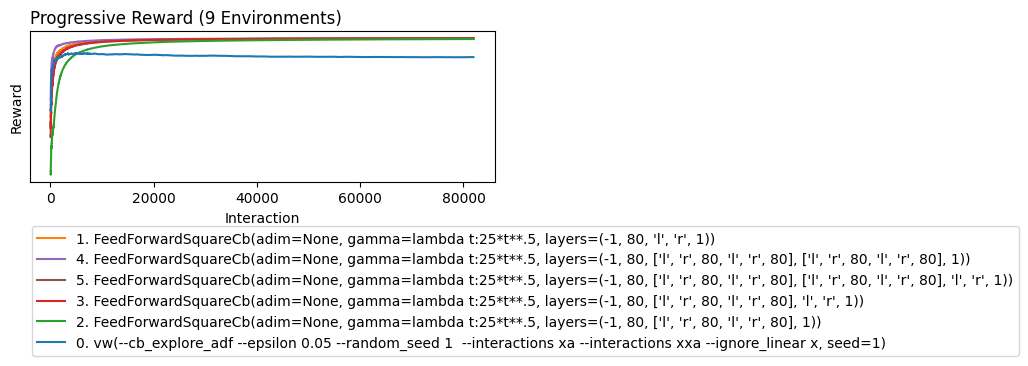

In [11]:
width,preres = 80,lambda w: ['l', 'r', w, 'l', 'r', w]
env = cb.Environments.from_custom(SimsEnvironment('series','is_pre',None,None,True,False,False,(6,5))).shuffle(n=9)
lrn = [cb.VowpalEpsilonLearner(features=[1,'a','xa','xxa']),
    FeedForwardSquareCb([-1, width, 'l', 'r', 1], gamma='lambda t:25*t**.5'),
    FeedForwardSquareCb([-1, width, preres(width), 1], gamma='lambda t:25*t**.5'),
    FeedForwardSquareCb([-1, width, preres(width), 'l', 'r', 1], gamma='lambda t:25*t**.5'),
    FeedForwardSquareCb([-1, width, preres(width), preres(width), 1], gamma='lambda t:25*t**.5'),
    FeedForwardSquareCb([-1, width, preres(width), preres(width), 'l', 'r', 1], gamma='lambda t:25*t**.5')]
cb.Experiment(env,lrn).run('sims_networks.log.gz',processes=35,quiet=True).plot_learners(xlim=(100,None))

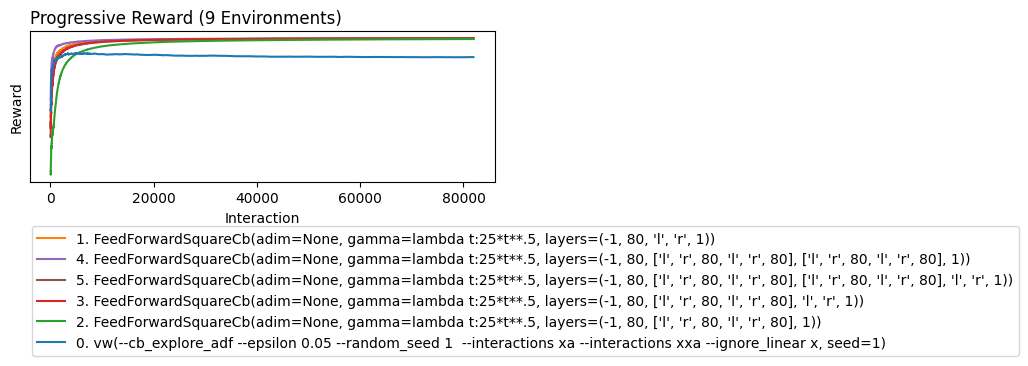

In [8]:
import coba as cb
import matplotlib.pyplot as plt
#out = cb.Result.from_file('sims_networks.log.gz')
plt.figure(figsize=(6,3))
out.where(learner_id={'<':6}).plot_learners(xlim=(100,None),yticks=False)

We shortened 2912 learner evaluations because they were longer than the shortest environment.


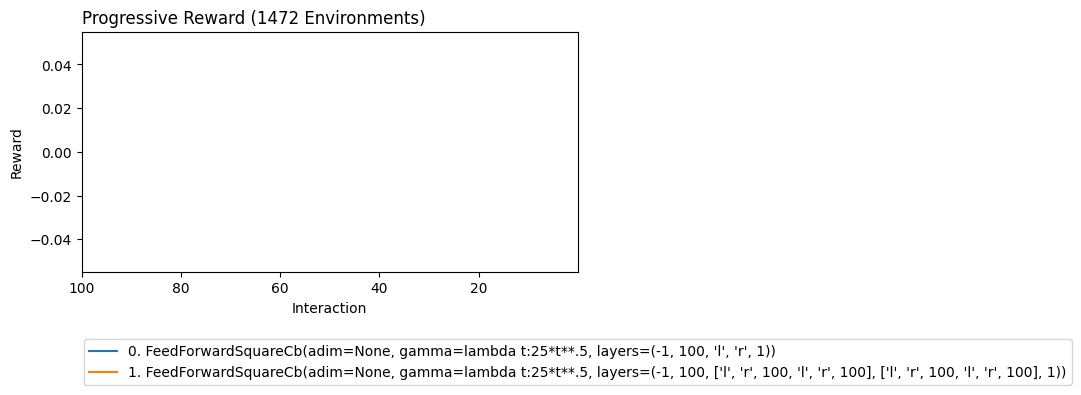

In [25]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats   = ['main1','series']
    pids    = all_pids()
    scalers = [None,RobustScaler(),MinMaxScaler(),StandardScaler()]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,scalers,scalers):
        winstp = (6,5) if feat == 'series' else None
        envs.append(SimsEnvironment(feat,'is_pre',pid,pscaler,gscaler,True,False,False,winstp))

    env = cb.Environments(*envs)
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 100

    lrn = [
        FeedForwardSquareCb([-1, width, 'l', 'r', 1], gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, width, preres(width), preres(width), 1], gamma='lambda t:25*t**.5'),
    ]

    return cb.Experiment(env,lrn,LooEval(.9)).run(log,processes=cores,quiet=True)

out = local('allthings.log.gz',35)
out.plot_learners(xlim=(100,None))

In [ ]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats   = ['series']
    pids    = all_pids()
    scalers = [None,RobustScaler(),MinMaxScaler(),StandardScaler()]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,scalers,scalers):
        winstp = (6,5) if feat == 'series' else None
        envs.append(SimsEnvironment(feat,'is_pre',pid,pscaler,gscaler,True,False,False,winstp))

    env = cb.Environments(*envs).shuffle(n=4)
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 100

    lrn = [
        FeedForwardSquareCb([-1, width, 'l', 'r', 1], gamma='lambda t:25*t**.5'),
        FeedForwardSquareCb([-1, width, preres(width), preres(width), 1], gamma='lambda t:25*t**.5'),
    ]

    return cb.Experiment(env,lrn,LooEval(.9)).run(log,processes=cores,quiet=True)

out = local('allthings2.log.gz',35)
out.plot_learners(xlim=(100,None))

We shortened 720 learner evaluations because they were longer than the shortest environment.


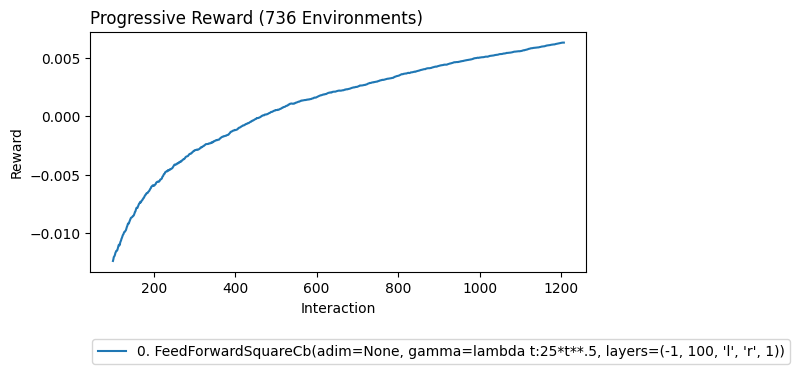

In [30]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler(),StandardScaler(),RobustScaler(with_scaling=False),StandardScaler(with_std=False)]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        winstp = (6,5) if feat == 'series' else None
        envs.append(SimsEnvironment(feat,'is_pre',pid,pscaler,gscaler,True,False,False,winstp))

    env = cb.Environments(*envs).shuffle(n=4)
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 100

    lrn = [
        FeedForwardSquareCb([-1, width, 'l', 'r', 1], gamma='lambda t:25*t**.5'),
        #FeedForwardSquareCb([-1, width, preres(width), preres(width), 1], gamma='lambda t:25*t**.5'),
    ]

    return cb.Experiment(env,lrn,LooEval(.9)).run(log,processes=cores,quiet=True)

out = local('allthings3.log.gz',35)
out.plot_learners(xlim=(100,None))

In [ ]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pre',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))

    env = cb.Environments(*envs).shuffle(n=4)
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 100

    lrn = [
        FeedForwardSimsCb([-1, width, 'l', 'r', 1], gamma='lambda t:25*t**.5', tz=100),
        FeedForwardSimsCb([-1, width, 'l', 'r', 1], gamma='lambda t:25*t**.5', tz=500),
    ]

    return cb.Experiment(env,lrn,[LooSimsEval(0),LooSimsEval(.9)]).run(log,processes=cores,quiet=True)

out = local('allthings5.log.gz',35)
out.plot_learners(xlim=(100,None))

We removed 109 environment_id because more than one existed for each full_name.
We removed 1 environment_id because it did not exist for every full_name.
We shortened 20 learner evaluations because they were longer than the shortest environment.


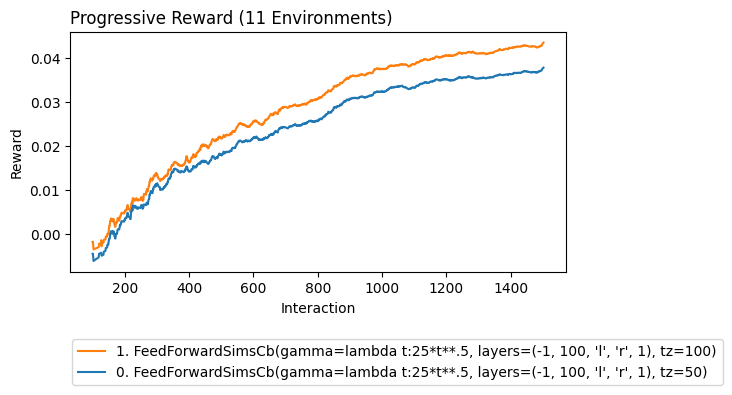

Background process 480846 failed unexpectedly with exit code 1.
Background process 480392 failed unexpectedly with exit code 1.
Background process 481294 failed unexpectedly with exit code -2.


In [38]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pre',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))

    env = cb.Environments(*envs).shuffle(n=4)
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 100

    lrn = [
        FeedForwardSimsCb([-1, width, 'l', 'r', 1], gamma='lambda t:25*t**.5', tz=50),
        FeedForwardSimsCb([-1, width, 'l', 'r', 1], gamma='lambda t:25*t**.5', tz=100),
    ]

    return cb.Experiment(env,lrn,[LooSimsEval(0),LooSimsEval(.9)]).run(log,processes=cores,quiet=True)

out = local('allthings6.log.gz',35)
out.plot_learners(xlim=(100,None))

We shortened 32 learner evaluations because they were longer than the shortest environment.


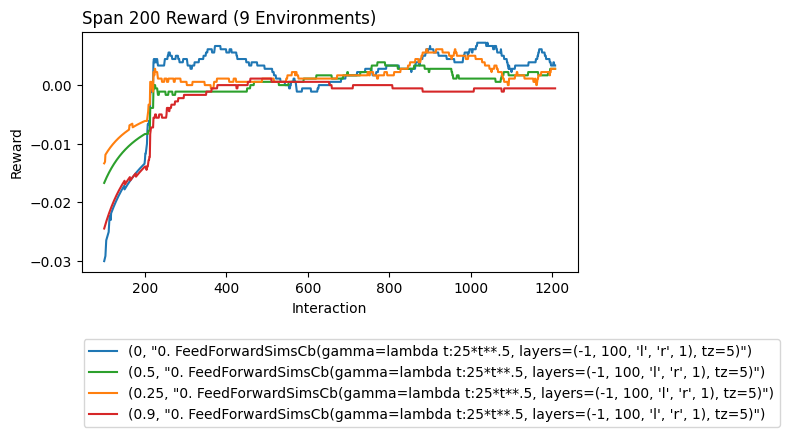

In [50]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pre',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))

    env = cb.Environments(*envs).shuffle(n=1)[:9]
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 100

    lrn = [
        FeedForwardSimsCb([-1, width, 'l', 'r', 1], gamma='lambda t:25*t**.5', tz=5),
    ]

    return cb.Experiment(env,lrn,[LooSimsEval(0),LooSimsEval(.25),LooSimsEval(.5),LooSimsEval(.9)]).run(log,processes=cores,quiet=True)

#out = local(None,35)
out.plot_learners(xlim=(100,None),l=['trn_pct','full_name'],span=200)

We shortened 64 learner evaluations because they were longer than the shortest environment.


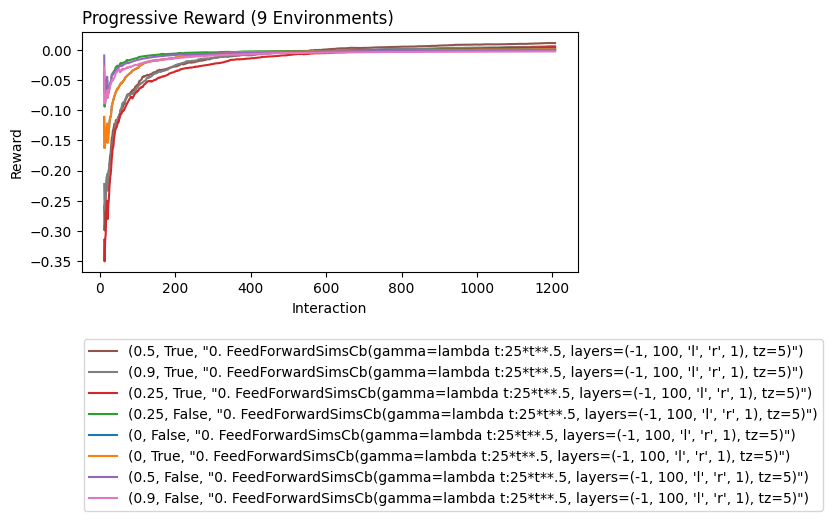

We shortened 64 learner evaluations because they were longer than the shortest environment.


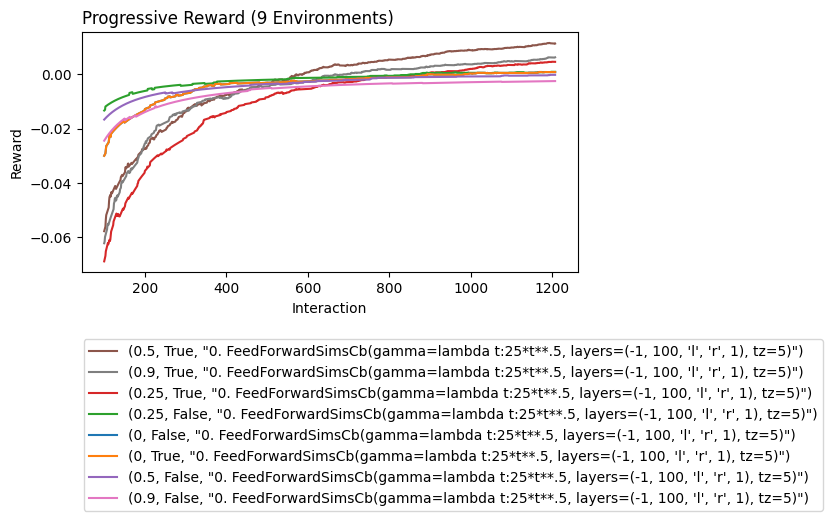

In [66]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pre',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))

    env = cb.Environments(*envs).shuffle(n=1)[:9]
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 100

    lrn = [
        FeedForwardSimsCb([-1, width, 'l', 'r', 1], gamma='lambda t:25*t**.5', tz=5),
    ]

    val = [
        LooSimsEval(t,r) for t,r in product([0,.25,.5,.9],[True,False])
    ]
        
    return cb.Experiment(env,lrn,val).run(log,processes=cores,quiet=True)

#out = local(None,35)
out.plot_learners(xlim=(12,None),l=['trn_pct','reset_out','full_name'])
out.plot_learners(xlim=(100,None),l=['trn_pct','reset_out','full_name'])

We shortened 240 learner evaluations because they were longer than the shortest environment.


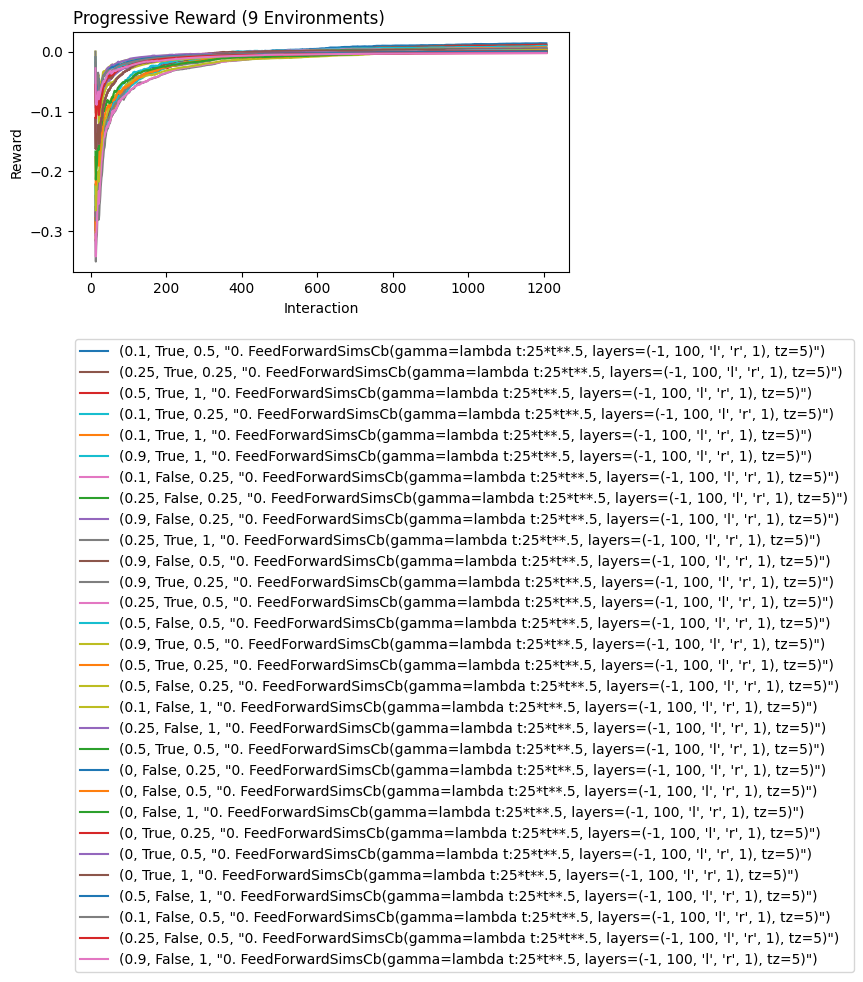

We shortened 240 learner evaluations because they were longer than the shortest environment.


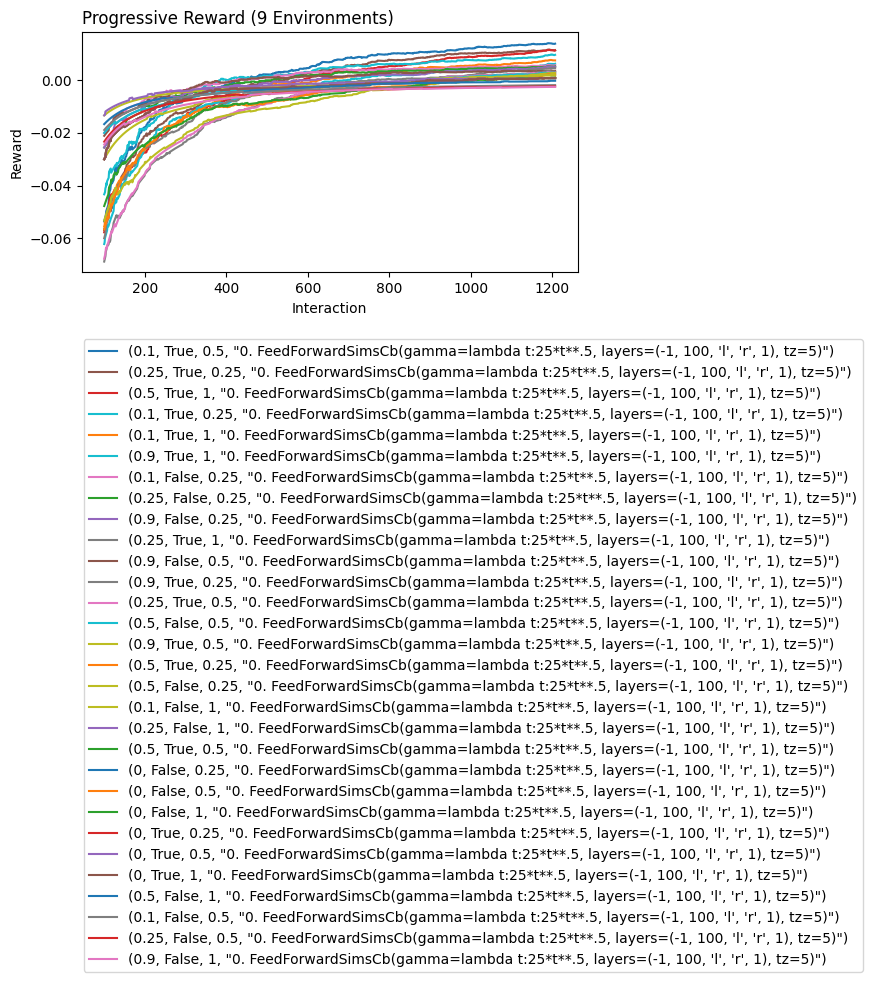

We shortened 270 learner evaluations because they were longer than the shortest environment.


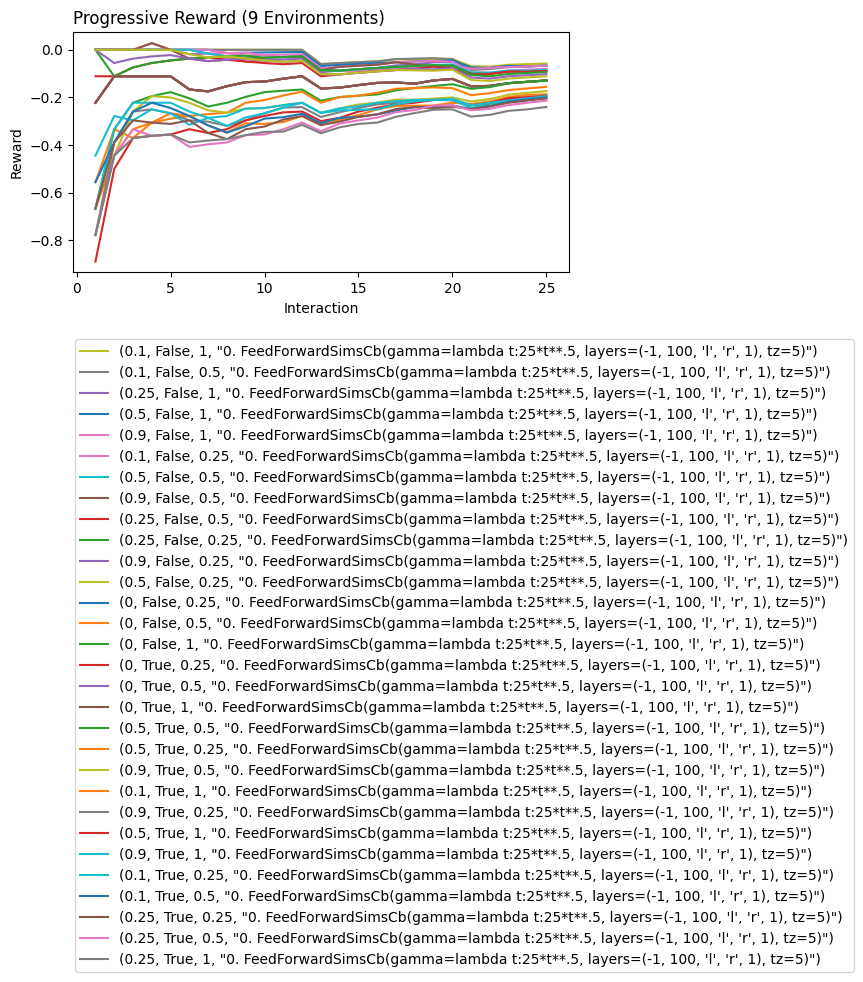

In [82]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pre',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))

    env = cb.Environments(*envs).shuffle(n=1)[:9]
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 100

    lrn = [
        FeedForwardSimsCb([-1, width, 'l', 'r', 1], gamma='lambda t:25*t**.5', tz=5),
    ]

    val = [
        LooSimsEval(t,r,p) for t,r,p in product([0,.1,.25,.5,.9],[True,False],[.25,.5,1])
    ]
        
    return cb.Experiment(env,lrn,val).run(log,processes=cores,quiet=True)

#out = local(None,35)
out.plot_learners(xlim=(12,None),l=['trn_pct','reset_out','prtr_scl','full_name'])
out.plot_learners(xlim=(100,None),l=['trn_pct','reset_out','prtr_scl','full_name'])
out.filter_fin(25).plot_learners(l=['trn_pct','reset_out','prtr_scl','full_name'])

We shortened 240 learner evaluations because they were longer than the shortest environment.


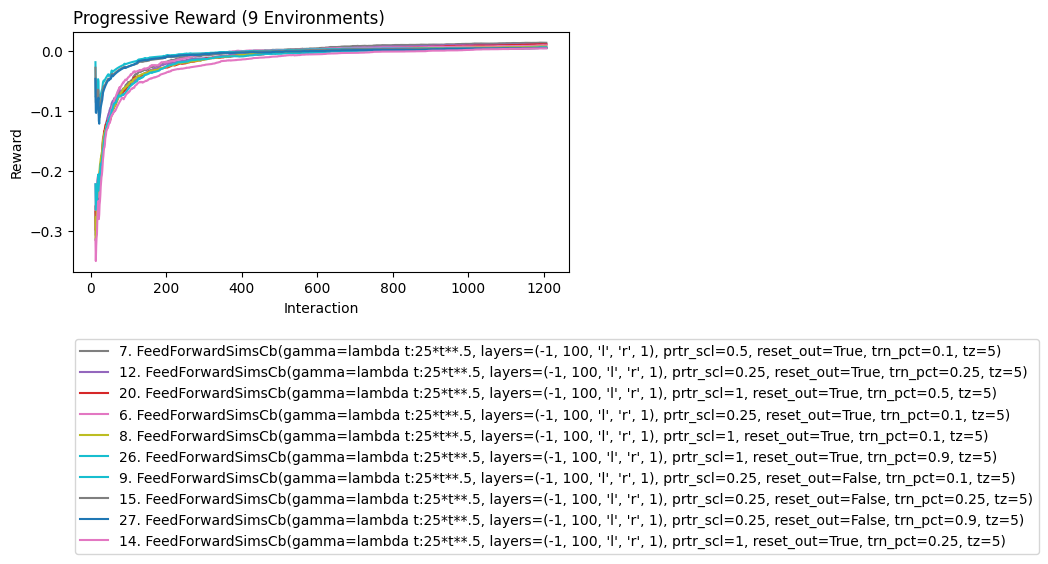

We shortened 240 learner evaluations because they were longer than the shortest environment.


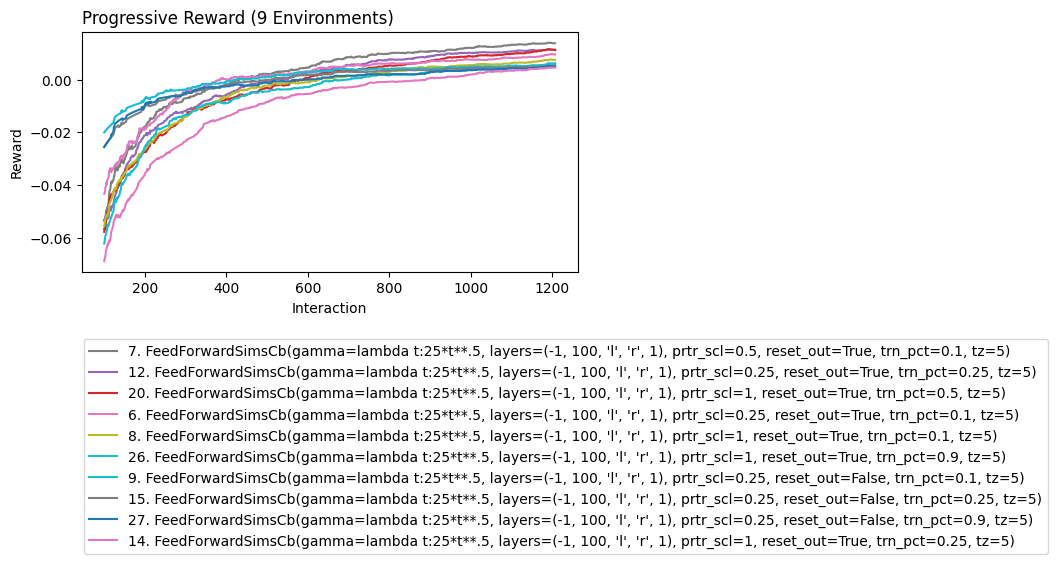

We shortened 270 learner evaluations because they were longer than the shortest environment.


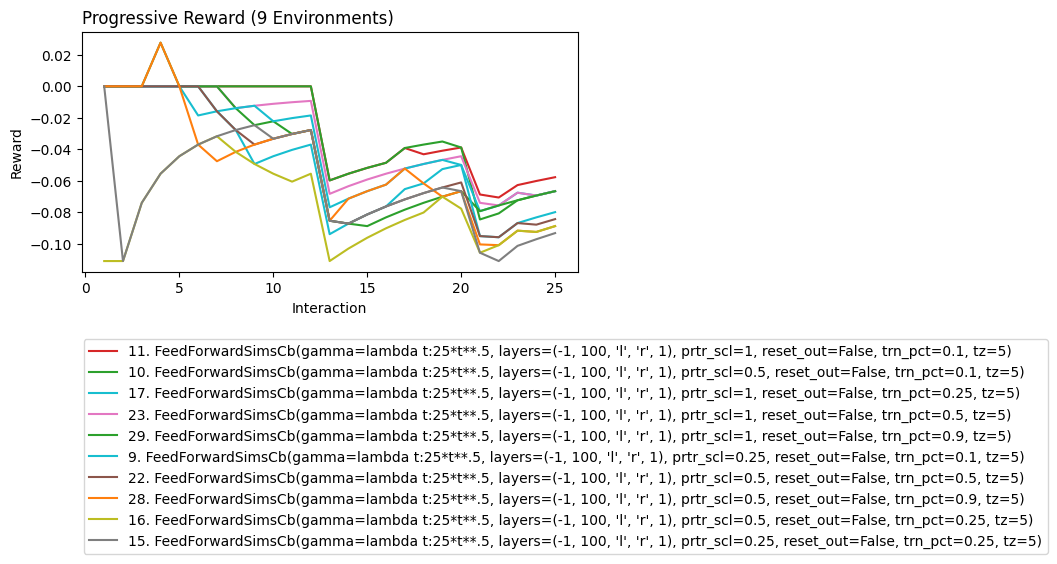

In [93]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pre',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))
    env = cb.Environments(*envs).shuffle(n=1)[:9]
    
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 100

    lrn = []
    for t,r,p in product([0,.1,.25,.5,.9],[True,False],[.25,.5,1]):
        lrn.append(FeedForwardSimsCb([-1, width, 'l', 'r', 1], 'lambda t:25*t**.5', 5, t, r, p))
        
    return cb.Experiment(env,lrn,LooSimsEval()).run(log,processes=cores,quiet=True)

#out = local(None,35)
out.plot_learners(xlim=(12,None),top_n=10)
out.plot_learners(xlim=(100,None),top_n=10)
out.filter_fin(25).plot_learners(top_n=10)

In [98]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pre',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))
    env = cb.Environments(*envs).shuffle(n=1)
    
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]
    width  = 100

    lrn = []
    for t,r,p in product([.1,.25,.5],[False],[.1,.25]):
        lrn.append(FeedForwardSimsCb([-1, width, 'l', 'r', 1], 'lambda t:25*t**.5', 5, t, r, p))
        
    return cb.Experiment(env,lrn,LooSimsEval()).run(log,processes=cores,quiet=True)

out = local(None,35)
out.plot_learners(xlim=(12,None),top_n=None)
out.plot_learners(xlim=(100,None),top_n=None)
out.filter_fin(25).plot_learners(top_n=None)

This result does not contain any data to plot.
This result does not contain any data to plot.
There was no None which was finished for every None.
This result does not contain any data to plot.


We shortened 216 learner evaluations because they were longer than the shortest environment.


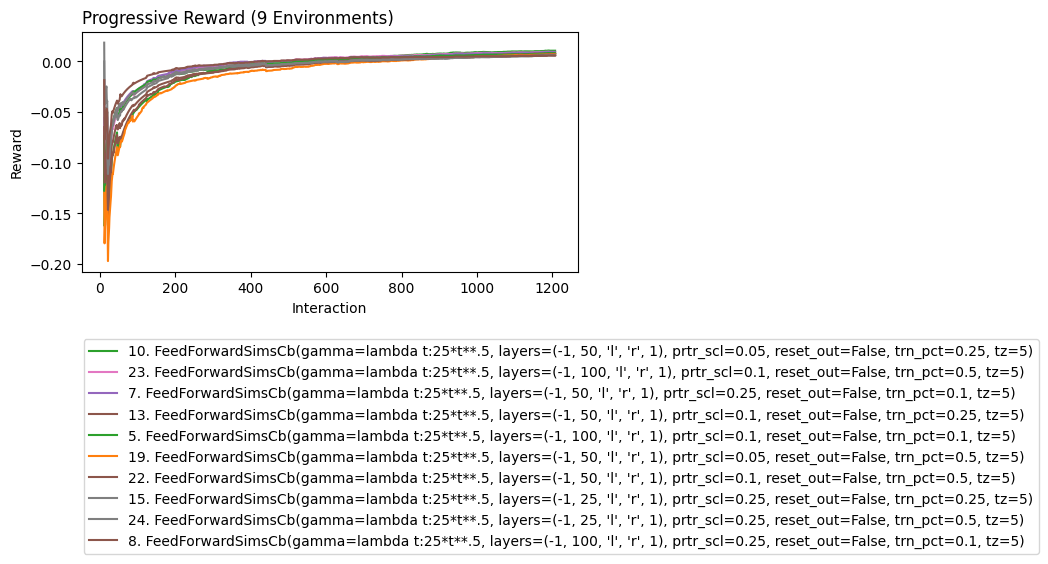

We shortened 216 learner evaluations because they were longer than the shortest environment.


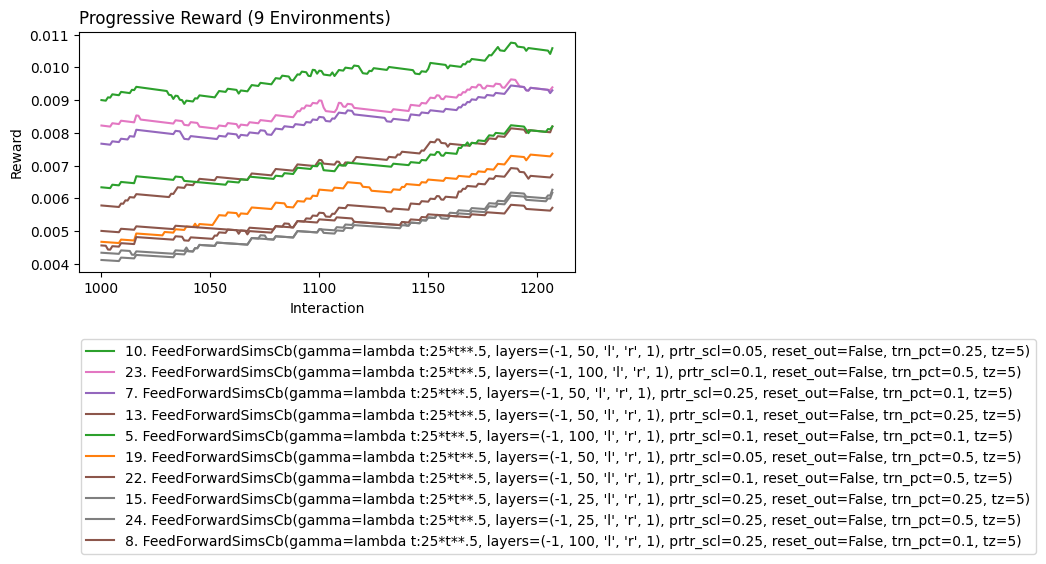

We shortened 243 learner evaluations because they were longer than the shortest environment.


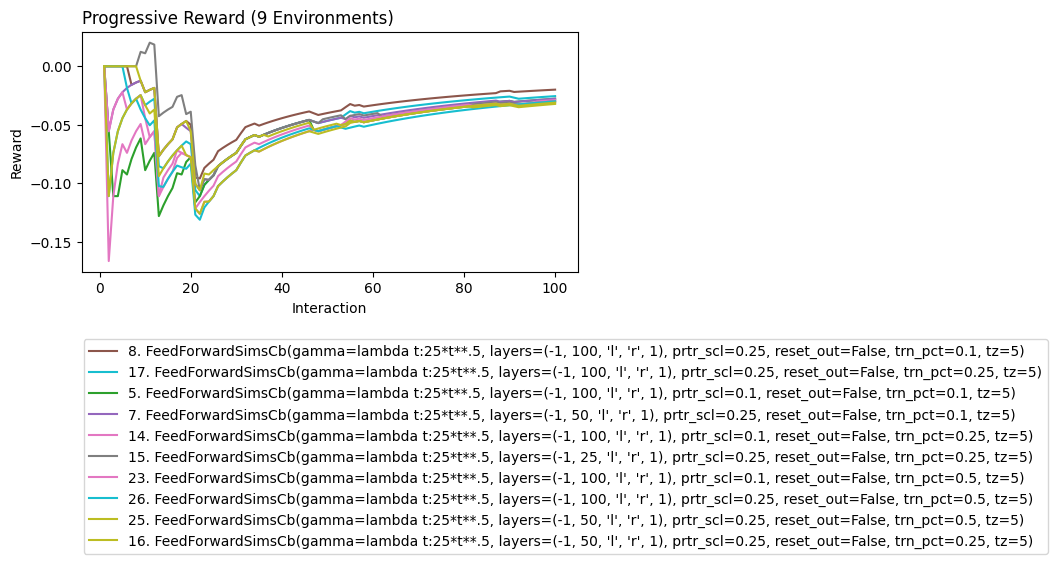

In [102]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pre',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))
    env = cb.Environments(*envs).shuffle(n=1)[:9]
    
    preres = lambda w: ['l', 'r', w, 'l', 'r', w]

    lrn = []
    for t,r,p,w in product([.1,.25,.5],[False],[.05,.1,.25],[25,50,100]):
        lrn.append(FeedForwardSimsCb([-1, w, 'l', 'r', 1], 'lambda t:25*t**.5', 5, t, r, p))
        
    return cb.Experiment(env,lrn,LooSimsEval()).run(log,processes=cores,quiet=True)

#out = local(None,35)
out.plot_learners(xlim=(12,None),top_n=10)
out.plot_learners(xlim=(1000,None),top_n=10)
out.filter_fin(100).plot_learners(top_n=10)

We shortened 1080 learner evaluations because they were longer than the shortest environment.


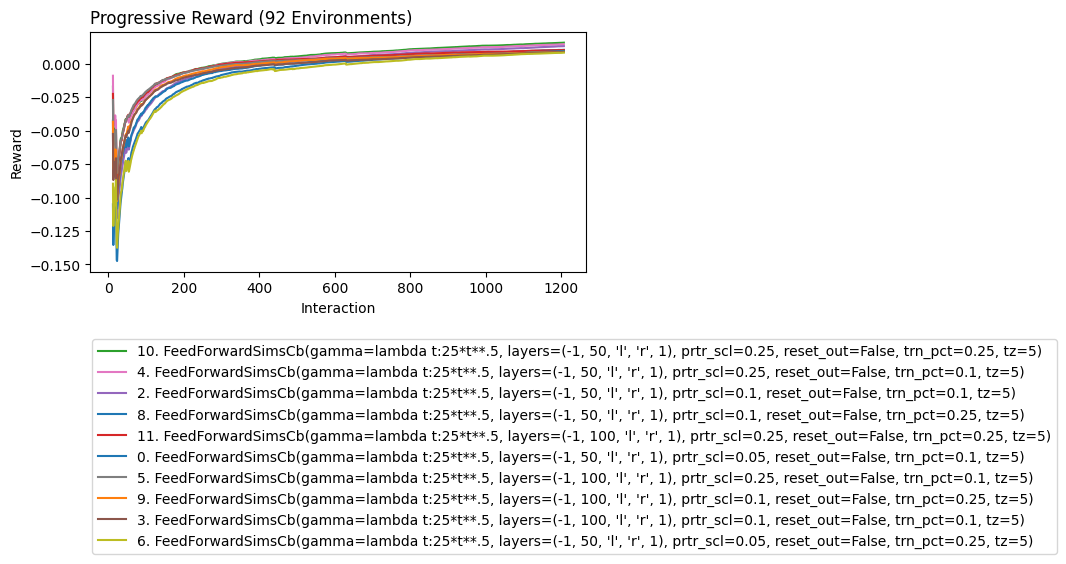

We shortened 1080 learner evaluations because they were longer than the shortest environment.


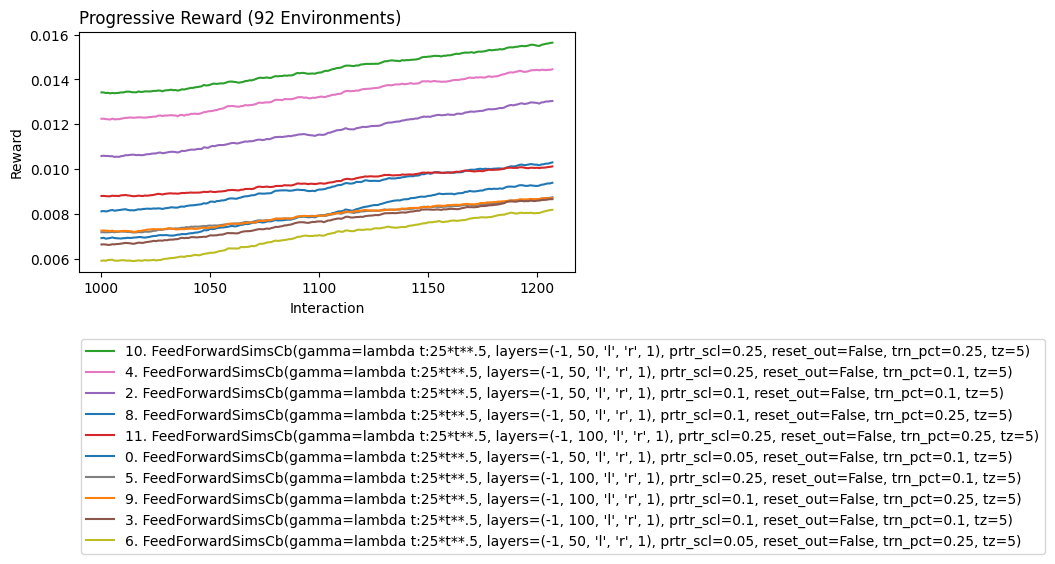

We shortened 1104 learner evaluations because they were longer than the shortest environment.


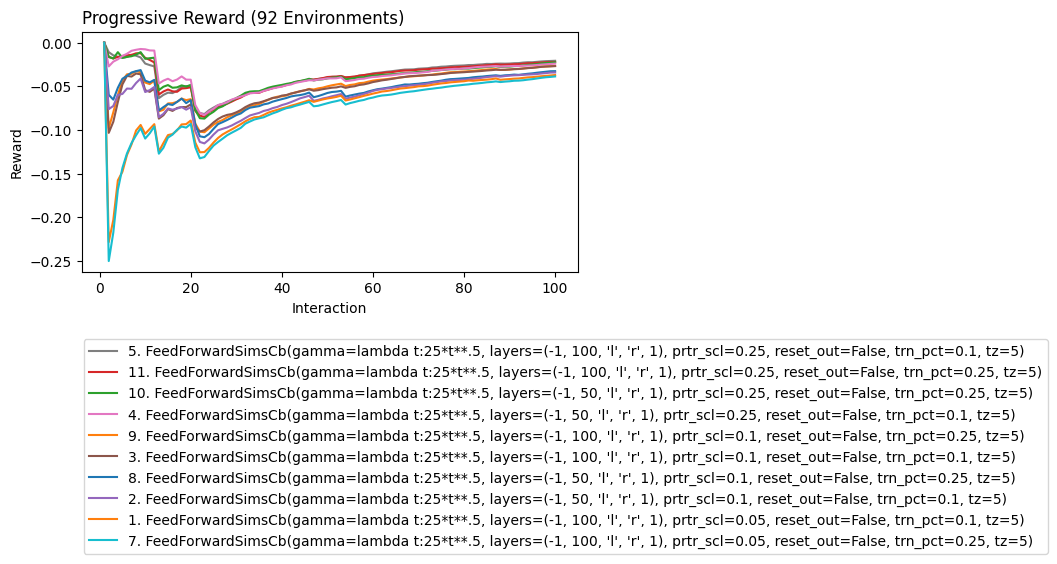

In [103]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pre',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))
    env = cb.Environments(*envs).shuffle(n=2)

    preres = lambda w: ['l', 'r', w, 'l', 'r', w]

    lrn = []
    for t,r,p,w in product([.1,.25],[False],[.05,.1,.25],[50,100]):
        lrn.append(FeedForwardSimsCb([-1, w, 'l', 'r', 1], 'lambda t:25*t**.5', 5, t, r, p))

    return cb.Experiment(env,lrn,LooSimsEval()).run(log,processes=cores,quiet=True)

out = local(None,35)
out.plot_learners(xlim=(12,None),top_n=10)
out.plot_learners(xlim=(1000,None),top_n=10)
out.filter_fin(100).plot_learners(top_n=10)

We shortened 1080 learner evaluations because they were longer than the shortest environment.


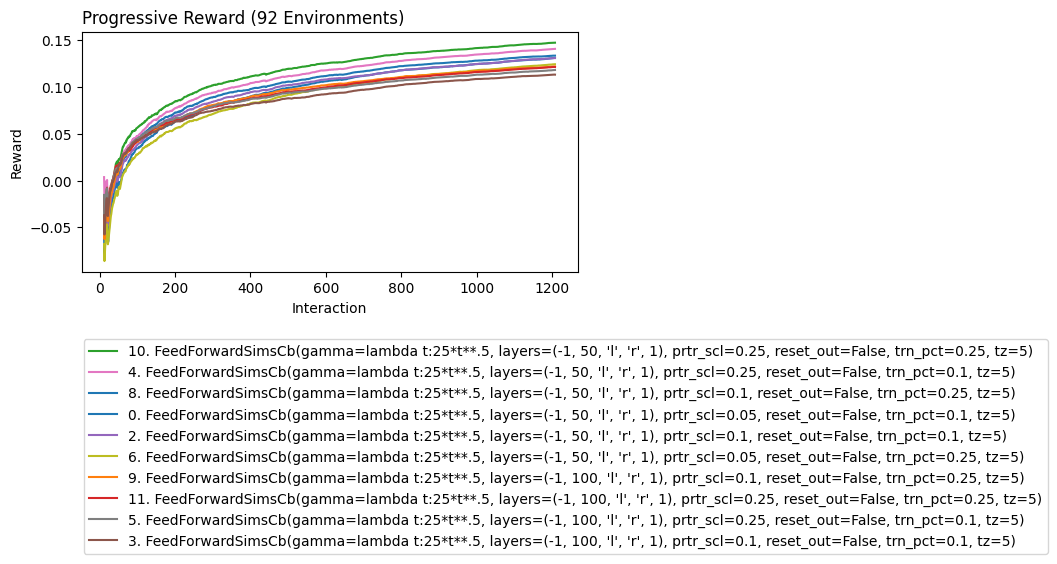

We shortened 1080 learner evaluations because they were longer than the shortest environment.


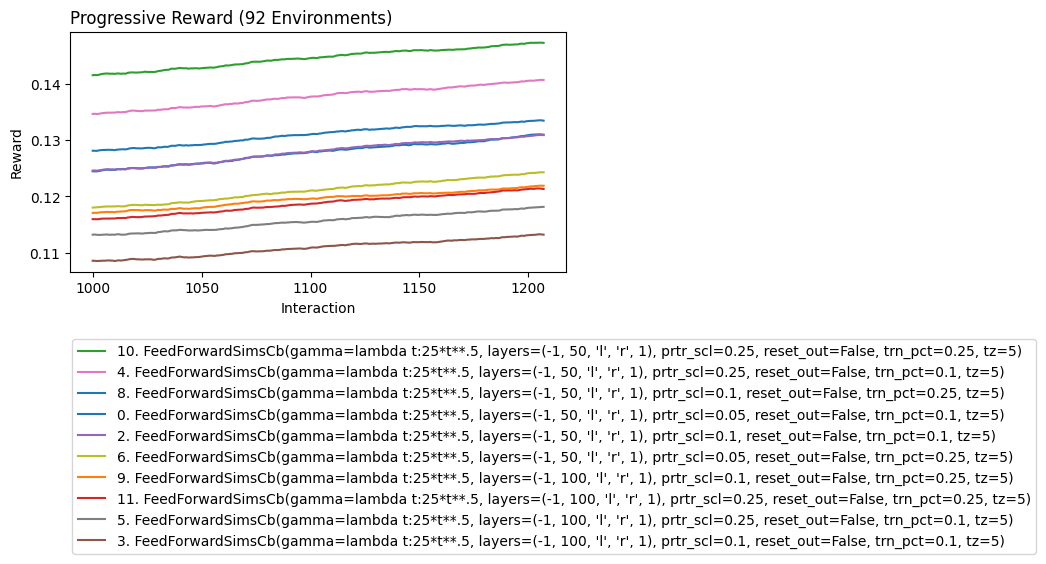

We shortened 1104 learner evaluations because they were longer than the shortest environment.


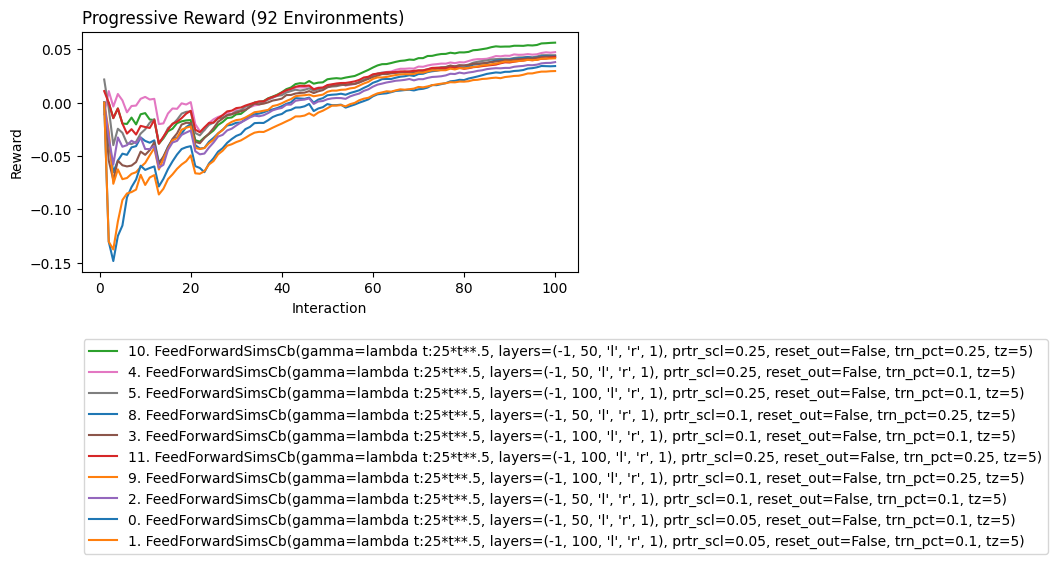

In [108]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pp',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))
    env = cb.Environments(*envs).shuffle(n=2)

    preres = lambda w: ['l', 'r', w, 'l', 'r', w]

    lrn = []
    for t,r,p,w in product([.1,.25],[False],[.05,.1,.25],[50,100]):
        lrn.append(FeedForwardSimsCb([-1, w, 'l', 'r', 1], 'lambda t:25*t**.5', 5, t, r, p))

    return cb.Experiment(env,lrn,LooSimsEval()).run(log,processes=cores,quiet=True)

out = local(None,35)
out.plot_learners(xlim=(12,None),top_n=10)
out.plot_learners(xlim=(1000,None),top_n=10)
out.filter_fin(100).plot_learners(top_n=10)

We shortened 3420 learner evaluations because they were longer than the shortest environment.


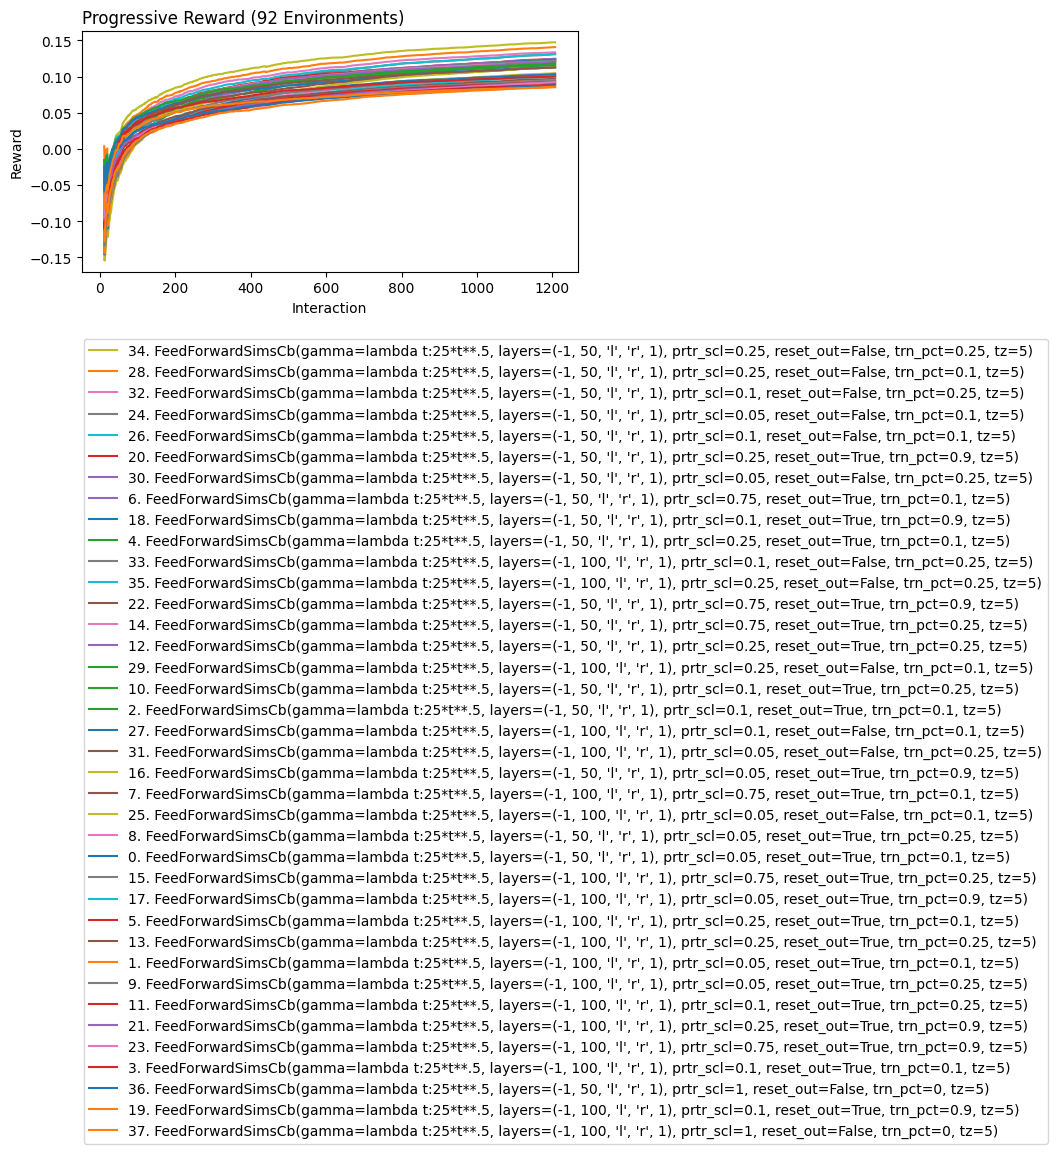

We shortened 3420 learner evaluations because they were longer than the shortest environment.


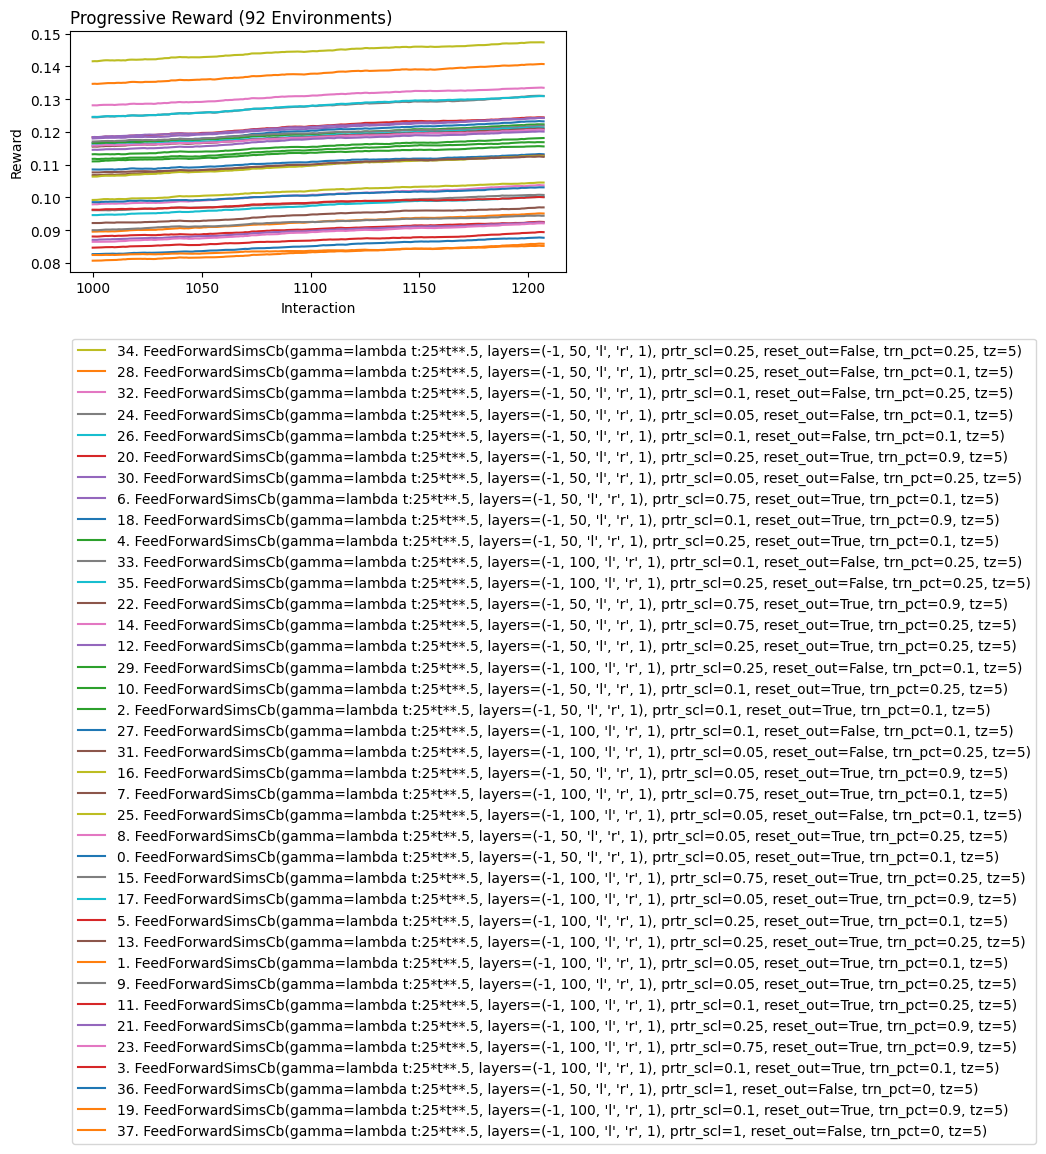

We shortened 3496 learner evaluations because they were longer than the shortest environment.


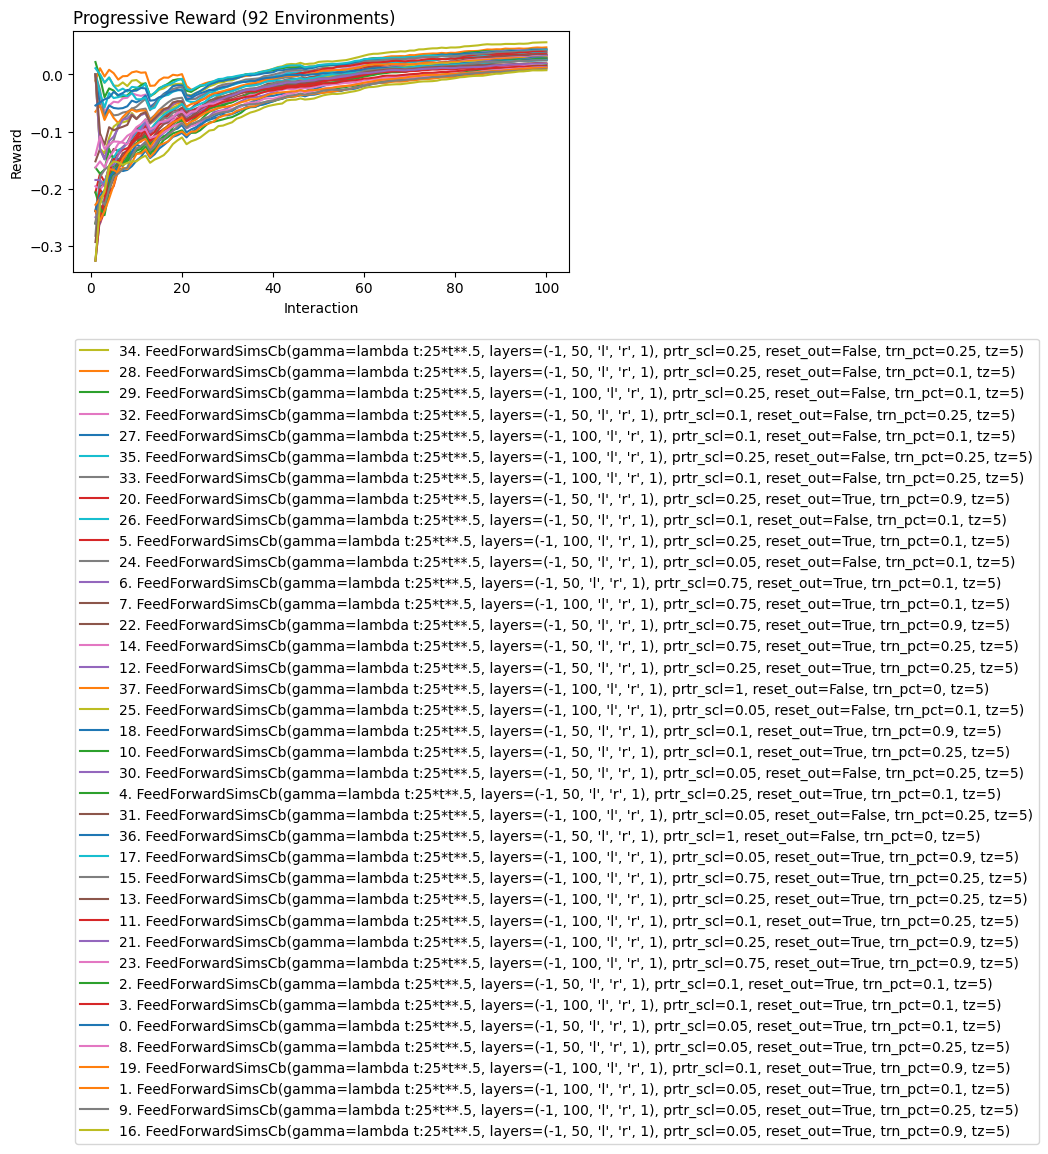

In [116]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pp',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))
    env = cb.Environments(*envs).shuffle(n=2)

    preres = lambda w: ['l', 'r', w, 'l', 'r', w]

    lrn = []
    for t,r,p,w in product([.1,.25,.9],[True],[.05,.1,.25,.75],[50,100]):
        lrn.append(FeedForwardSimsCb([-1, w, 'l', 'r', 1], 'lambda t:25*t**.5', 5, t, r, p))
    for t,r,p,w in product([.1,.25],[False],[.05,.1,.25],[50,100]):
        lrn.append(FeedForwardSimsCb([-1, w, 'l', 'r', 1], 'lambda t:25*t**.5', 5, t, r, p))
    for w in [50,100]:
        lrn.append(FeedForwardSimsCb([-1, w, 'l', 'r', 1], 'lambda t:25*t**.5', 5, 0))
    return cb.Experiment(env,lrn,LooSimsEval()).run(log,processes=cores,quiet=True)

#out = local('fullpp.log.gz',38)
out = cb.Result.from_file('fullpp.log.gz')
out.plot_learners(xlim=(12,None))
out.plot_learners(xlim=(1000,None))
out.filter_fin(100).plot_learners()

Exception ignored in: <function Workspace.__del__ at 0x7f948eedbf40>
Traceback (most recent call last):
  File "/home/mrucker/miniconda3/envs/diss/lib/python3.10/site-packages/vowpalwabbit/pyvw.py", line 788, in __del__
  File "/home/mrucker/miniconda3/envs/diss/lib/python3.10/site-packages/vowpalwabbit/pyvw.py", line 746, in finish
AttributeError: 'NoneType' object has no attribute 'finish'
Exception ignored in: <function Workspace.__del__ at 0x7fdb062bff40>
Traceback (most recent call last):
  File "/home/mrucker/miniconda3/envs/diss/lib/python3.10/site-packages/vowpalwabbit/pyvw.py", line 788, in __del__
  File "/home/mrucker/miniconda3/envs/diss/lib/python3.10/site-packages/vowpalwabbit/pyvw.py", line 746, in finish
AttributeError: 'NoneType' object has no attribute 'finish'
Exception ignored in: <function Workspace.__del__ at 0x7f456d2a7f40>
Traceback (most recent call last):
  File "/home/mrucker/miniconda3/envs/diss/lib/python3.10/site-packages/vowpalwabbit/pyvw.py", line 788, i

We shortened 180 learner evaluations because they were longer than the shortest environment.


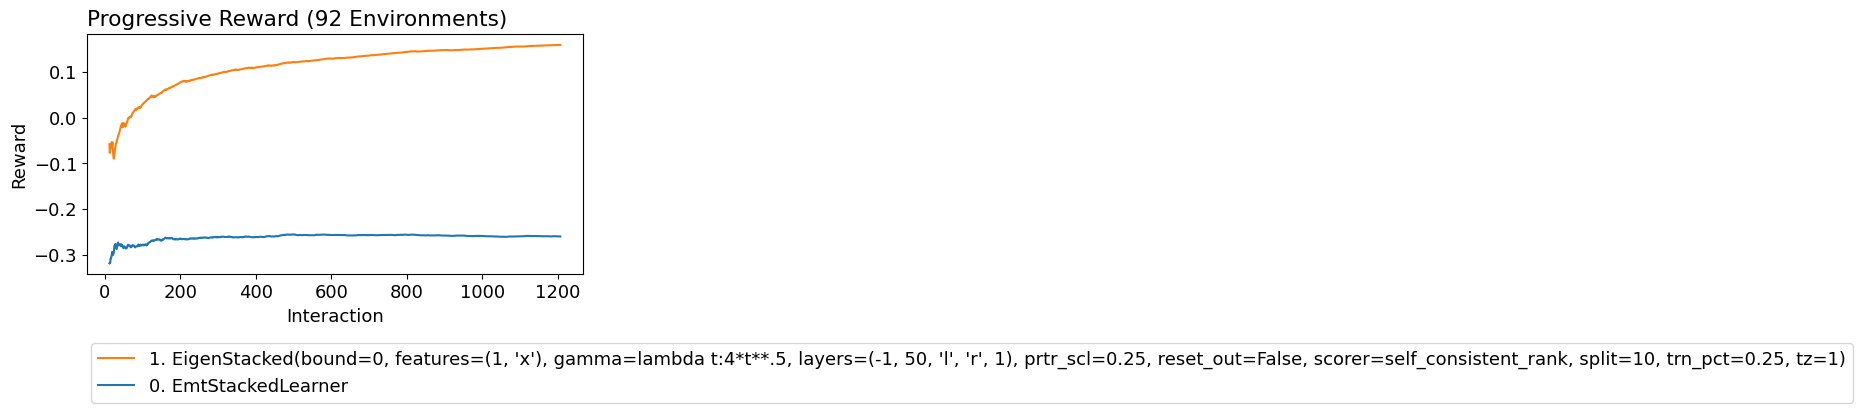

We shortened 180 learner evaluations because they were longer than the shortest environment.


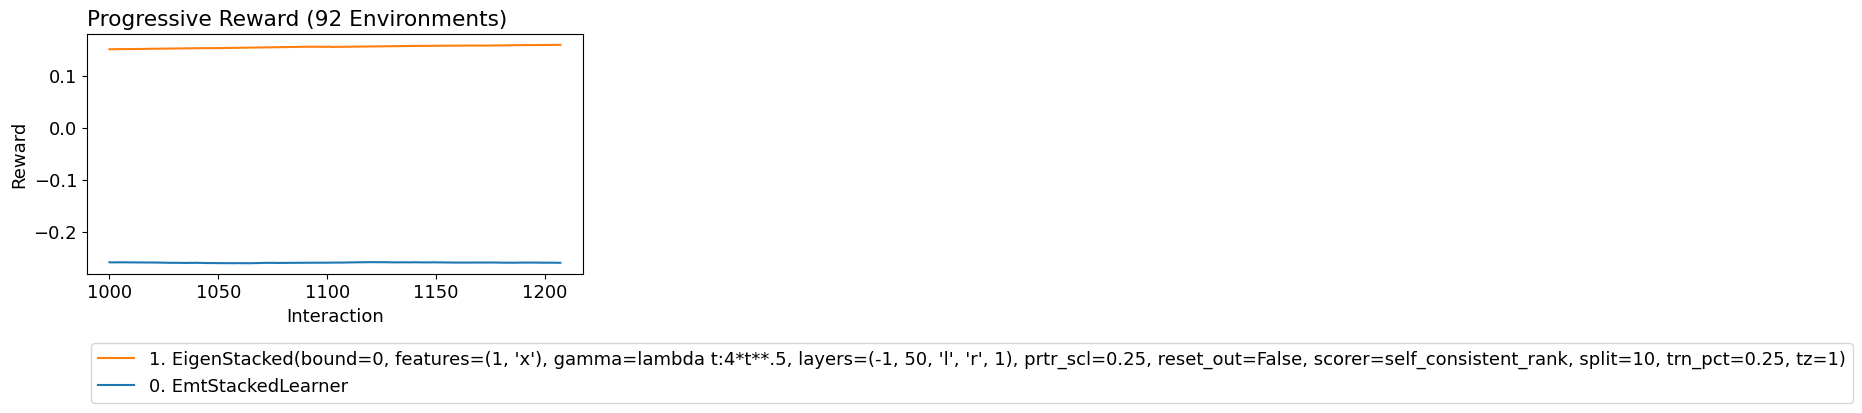

We shortened 184 learner evaluations because they were longer than the shortest environment.


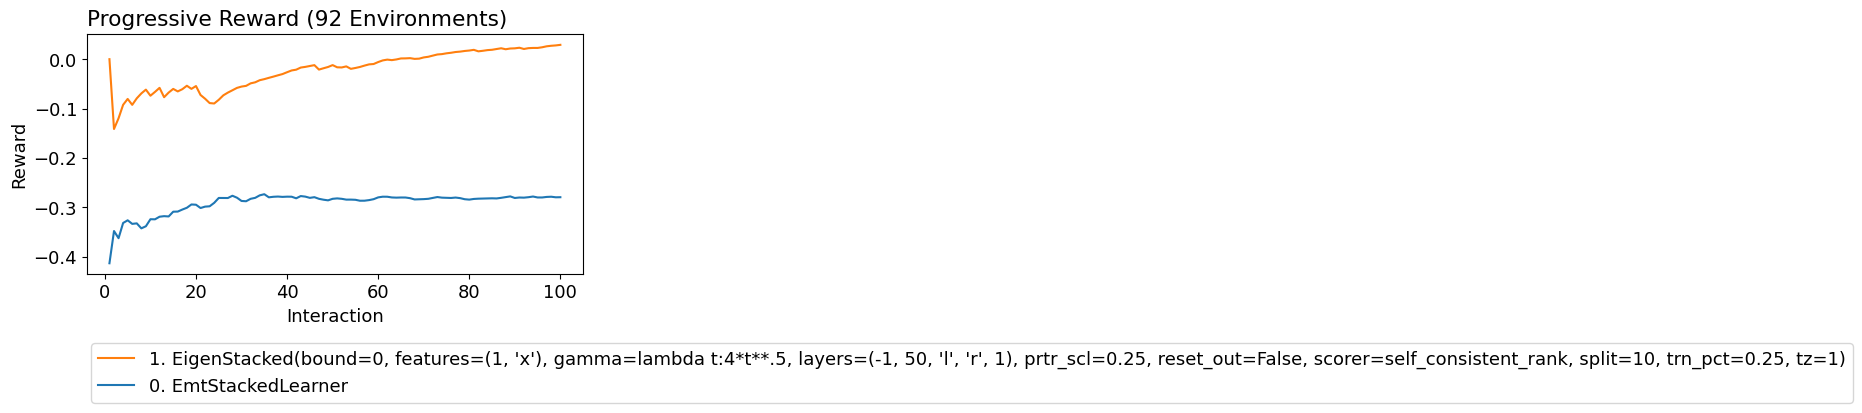

In [68]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pp',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))
    env = cb.Environments(*envs).shuffle(n=2)

    lrn = []
#    for t,r,p,w,g in product([.25],[False],[.25],[50],[4]):
#       lrn.append(FeedForwardSimsCb([-1, w, 'l', 'r', 1], f'lambda t:{g}*t**.5', 1, t, r, p))
    for t,r,p,w,g in product([.25],[False],[.25],[50],[4]):
        lrn.append(EmtStackedLearner(EMT(split=10,features=[1,'x']),None))
        lrn.append(EmtStackedLearner(EMT(split=10,features=[1,'x']),FeedForwardSimsCb([-1, w, 'l', 'r', 1], f'lambda t:{g}*t**.5', 1, t, r, p)))
#    for w,g in product([50],[4]):
#        lrn.append(FeedForwardSimsCb([-1, w, 'l', 'r', 1], f'lambda t:{g}*t**.5', 1, 0))
    return cb.Experiment(env,lrn,LooSimsEval()).run(log,processes=cores,quiet=True)

out = local(None,38)
#out = cb.Result.from_file('fullpp5.log.gz')
out.plot_learners(xlim=(12,None))
out.plot_learners(xlim=(1000,None))
out.filter_fin(100).plot_learners()

In [1]:
import coba as cb

pp1 = cb.Result.from_file('fullpp.log.gz')
pp2 = cb.Result.from_file('fullpp2.log.gz')
pp3 = cb.Result.from_file('fullpp3.log.gz')
pp4 = cb.Result.from_file('fullpp4.log.gz')

bdf1 = pp1.interactions.to_pandas()
bdf2 = pp2.interactions.to_pandas()
bdf3 = pp3.interactions.to_pandas()
bdf4 = pp4.interactions.to_pandas()

   learner_id             family              gamma              layers  prtr_scl  reset_out  trn_pct  tz
0          19  FeedForwardSimsCb  lambda t:25*t**.5  (-1, 100, l, r, 1)      0.10       True     0.90   5
1          24  FeedForwardSimsCb  lambda t:25*t**.5   (-1, 50, l, r, 1)      0.05      False     0.10   5
2          34  FeedForwardSimsCb  lambda t:25*t**.5   (-1, 50, l, r, 1)      0.25      False     0.25   5
3          37  FeedForwardSimsCb  lambda t:25*t**.5  (-1, 100, l, r, 1)      1.00      False     0.00   5


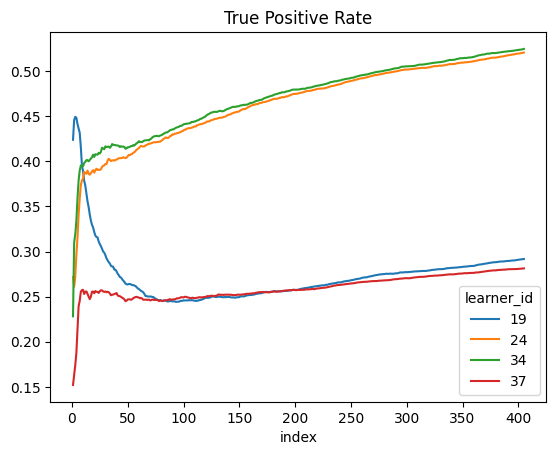

   learner_id             family             gamma             layers  prtr_scl  reset_out  trn_pct  tz
0           0  FeedForwardSimsCb  lambda t:2*t**.5  (-1, 50, l, r, 1)      0.05       True     0.10   1
1           4  FeedForwardSimsCb  lambda t:2*t**.5  (-1, 50, l, r, 1)      0.05       True     0.25   1
2          16  FeedForwardSimsCb  lambda t:2*t**.5  (-1, 50, l, r, 1)      0.10      False     0.25   1
3          17  FeedForwardSimsCb  lambda t:2*t**.5  (-1, 50, l, r, 1)      0.25      False     0.25   1


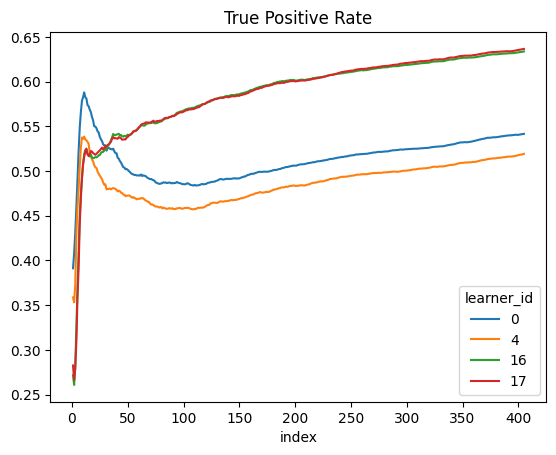

   learner_id             family             gamma             layers  prtr_scl  reset_out  trn_pct  tz
0           5  FeedForwardSimsCb  lambda t:8*t**.5  (-1, 50, l, r, 1)      0.25       True     0.25   1
1           6  FeedForwardSimsCb  lambda t:2*t**.5  (-1, 50, l, r, 1)      0.25      False     0.10   1
2           9  FeedForwardSimsCb  lambda t:2*t**.5  (-1, 50, l, r, 1)      0.25      False     0.25   1
3          14  FeedForwardSimsCb  lambda t:8*t**.5  (-1, 50, l, r, 1)      1.00      False     0.00   1


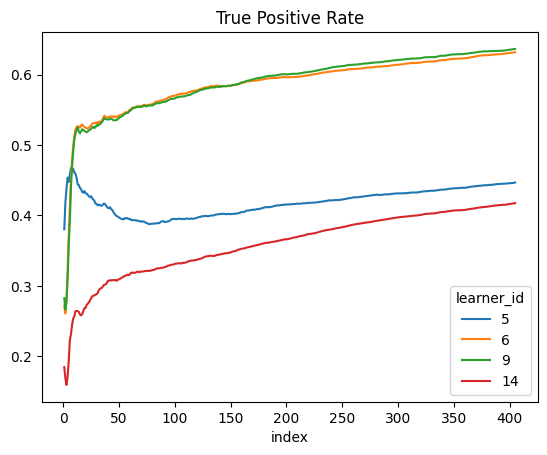

   learner_id bound             family features             gamma             layers  prtr_scl  reset_out                scorer split  trn_pct  tz
0           1  None  FeedForwardSimsCb     None  lambda t:8*t**.5  (-1, 50, l, r, 1)      0.25       True                  None  None     0.25   1
1           4     0       EigenStacked   (1, x)  lambda t:4*t**.5  (-1, 50, l, r, 1)      0.25      False  self_consistent_rank   200     0.25   1
2           5     0       EigenStacked   (1, x)  lambda t:8*t**.5  (-1, 50, l, r, 1)      0.25      False  self_consistent_rank   200     0.25   1
3           7  None  FeedForwardSimsCb     None  lambda t:8*t**.5  (-1, 50, l, r, 1)      1.00      False                  None  None     0.00   1


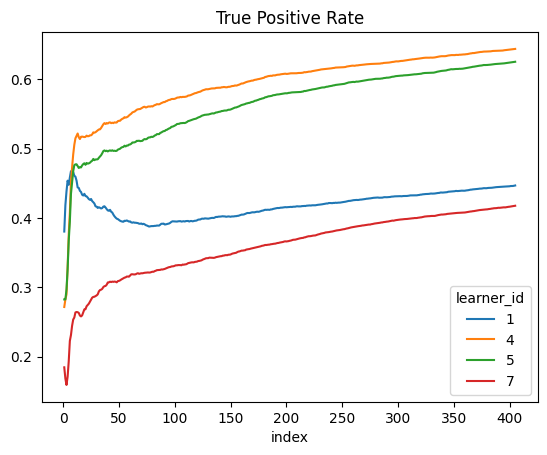

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
for pp,bdf in zip([pp1,pp2,pp3,pp4],[bdf1,bdf2,bdf3,bdf4]):
    df = bdf.copy()
    df = df[df.tl == 1]
    df[['fp','fn']] = df[['fn','fp']] # due to a bug in code, we need to swap these
    
    #fix index
    df['index'] = 1
    df['index'] = df.groupby(['environment_id','learner_id'])[['index']].expanding().sum().reset_index().drop('level_2',axis=1)['index'].tolist()
    
    #make all environments equal length
    df = df[df['index'] <= df.groupby(['environment_id','learner_id'])['index'].max().min()]
    
    #calculate tpr using a window size
    df['tpr'] = df.groupby(['environment_id','learner_id']).expanding()['tp'].mean().reset_index().drop('level_2',axis=1)['tp'].tolist()
    
    top_n = 2
    
    #get top 10 learner ids
    tprtop10 = df[df['index'] == df['index'].max()].groupby(['learner_id'])['tpr'].mean().reset_index().sort_values('tpr',ascending=False)['learner_id'][:top_n].tolist()
    tprbot10 = df[df['index'] == df['index'].max()].groupby(['learner_id'])['tpr'].mean().reset_index().sort_values('tpr',ascending=True )['learner_id'][:top_n].tolist()

    with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.max_colwidth', None, 'display.width', 1000):
        print(pp.where(learner_id=(tprtop10+tprbot10)).learners.to_pandas())
        df[df.learner_id.isin(tprtop10+tprbot10)].groupby(['learner_id','index'])['tpr'].mean().reset_index().pivot(columns= 'learner_id',index='index',values='tpr').plot(title='True Positive Rate')
        plt.show()


   learner_id bound             family features             gamma             layers  prtr_scl  reset_out                scorer split  trn_pct  tz
0           4     0       EigenStacked   (1, x)  lambda t:4*t**.5  (-1, 50, l, r, 1)      0.25      False  self_consistent_rank   200     0.25   1
1           7  None  FeedForwardSimsCb     None  lambda t:8*t**.5  (-1, 50, l, r, 1)      1.00      False                  None  None     0.00   1


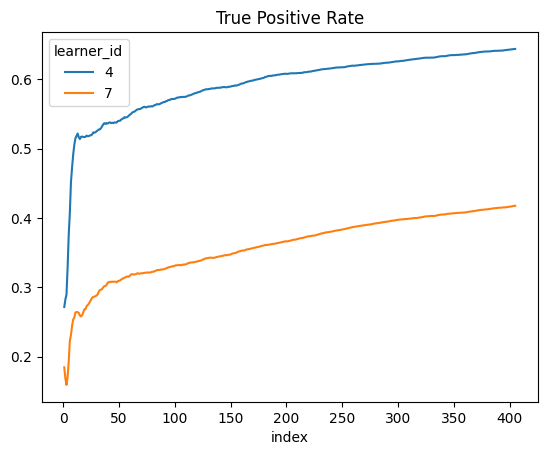

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

outs = []

for pp,bdf in zip([pp4],[bdf4]):
    df = bdf.copy()
    df = df[df.tl == 1]
    df[['fp','fn']] = df[['fn','fp']] # due to a bug in code, we need to swap these
    
    #fix index
    df['index'] = 1
    df['index'] = df.groupby(['environment_id','learner_id'])[['index']].expanding().sum().reset_index().drop('level_2',axis=1)['index'].tolist()
    
    #make all environments equal length
    df = df[df['index'] <= df.groupby(['environment_id','learner_id'])['index'].max().min()]
    
    #calculate tpr using a window size
    df['tpr'] = df.groupby(['environment_id','learner_id']).expanding()['tp'].mean().reset_index().drop('level_2',axis=1)['tp'].tolist()
    
    top_n = 1
    
    #get top 10 learner ids
    tprtop10 = df[df['index'] == df['index'].max()].groupby(['learner_id'])['tpr'].mean().reset_index().sort_values('tpr',ascending=False)['learner_id'][:top_n].tolist()
    tprbot10 = df[df['index'] == df['index'].max()].groupby(['learner_id'])['tpr'].mean().reset_index().sort_values('tpr',ascending=True )['learner_id'][:top_n].tolist()

    outs.append(df[df.learner_id.isin(tprtop10+tprbot10)])
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.max_colwidth', None, 'display.width', 1000):
        print(pp.where(learner_id=(tprtop10+tprbot10)).learners.to_pandas())
        df[df.learner_id.isin(tprtop10+tprbot10)].groupby(['learner_id','index'])['tpr'].mean().reset_index().pivot(columns= 'learner_id',index='index',values='tpr').plot(title='True Positive Rate')
        plt.show()


In [3]:
x = pd.concat(outs).groupby(['learner_id','index'])['tpr'].mean().reset_index().pivot(columns= 'learner_id',index='index',values='tpr')

<Axes: title={'center': 'True Positive Rate'}, xlabel='index'>

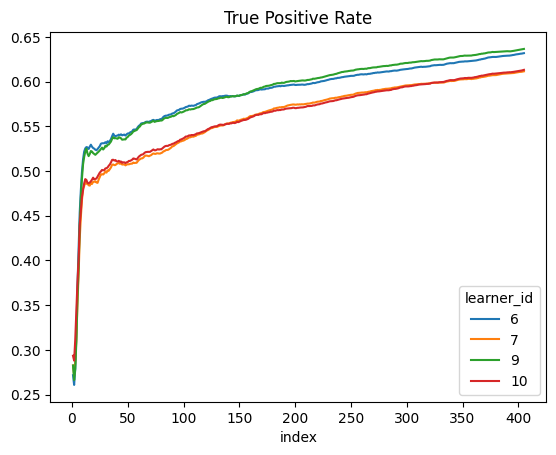

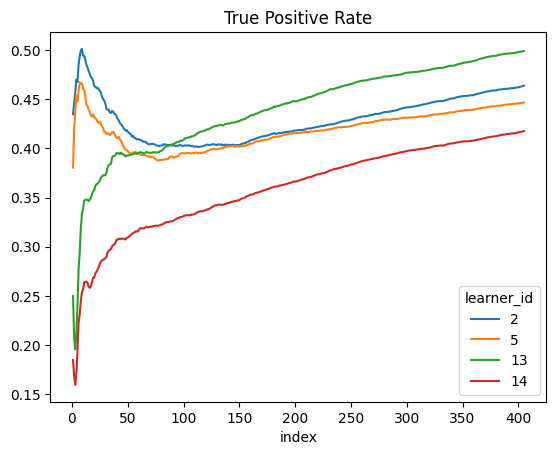

In [5]:
df = bdf0.copy()
df = df[df.tl == 1]
df[['fp','fn']] = df[['fn','fp']] # due to a bug in code, we need to swap these

#fix index
df['index'] = 1
df['index'] = df.groupby(['environment_id','learner_id'])[['index']].expanding().sum().reset_index().drop('level_2',axis=1)['index'].tolist()

#make all environments equal length
df = df[df['index'] <= df.groupby(['environment_id','learner_id'])['index'].max().min()]

#calculate tpr using a window size
df['tpr'] = df.groupby(['environment_id','learner_id']).expanding()['tp'].mean().reset_index().drop('level_2',axis=1)['tp'].tolist()

top_n = 4

#get top 10 learner ids
tprtop10 = df[df['index'] == df['index'].max()].groupby(['learner_id'])['tpr'].mean().reset_index().sort_values('tpr',ascending=False)['learner_id'][:top_n].tolist()
tprbot10 = df[df['index'] == df['index'].max()].groupby(['learner_id'])['tpr'].mean().reset_index().sort_values('tpr',ascending=True )['learner_id'][:top_n].tolist()

df[df.learner_id.isin(tprtop10)].groupby(['learner_id','index'])['tpr'].mean().reset_index().pivot(columns= 'learner_id',index='index',values='tpr').plot(title='True Positive Rate')
df[df.learner_id.isin(tprbot10)].groupby(['learner_id','index'])['tpr'].mean().reset_index().pivot(columns= 'learner_id',index='index',values='tpr').plot(title='True Positive Rate')

#x = df[df.learner_id.isin([4,7])].groupby(['learner_id','index'])['tpr'].mean().reset_index().pivot(columns='learner_id',index='index',values='tpr')
#x.plot(title='True Positive Rate')


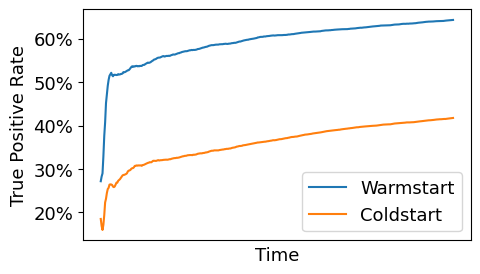

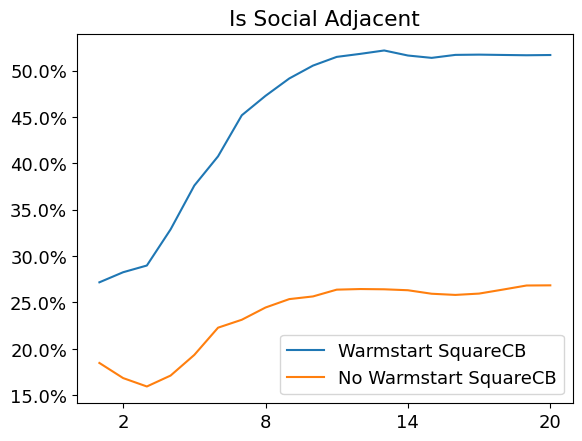

In [10]:
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

plt.rcParams.update({'font.size': 13}) # must set in top
x.columns = ['Warmstart','Coldstart']
ax = x.plot(figsize=(5,3))
ax.legend(loc='lower right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xlabel('Time')
ax.set_xticks([])
ax.set_ylabel('True Positive Rate')
plt.show()

plt.rcParams.update({'font.size': 13}) # must set in top
x.columns = ['Warmstart SquareCB','No Warmstart SquareCB']
ax = x.iloc[:20,:].plot(title = 'Is Social Adjacent')
ax.legend(loc='lower right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xticks([2,8,14,20])
ax.set_xlabel('')
plt.show()

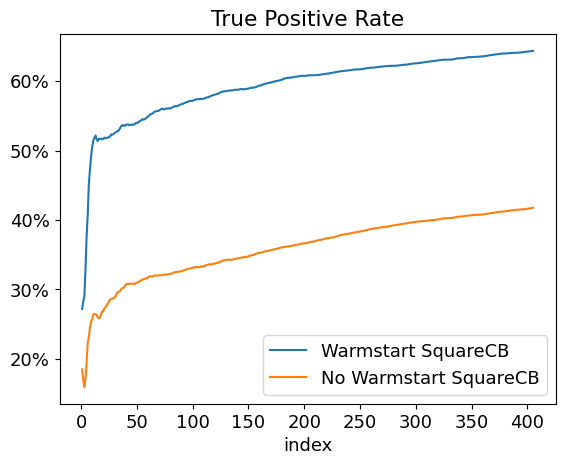

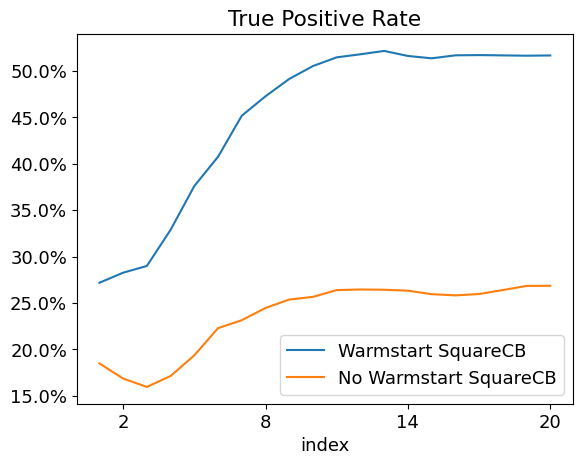

In [53]:
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick

plt.rcParams.update({'font.size': 13}) # must set in top
x.columns = ['Warmstart SquareCB','No Warmstart SquareCB']
ax = x.plot(title = 'True Positive Rate')
ax.legend(loc='lower right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.show()

plt.rcParams.update({'font.size': 13}) # must set in top
x.columns = ['Warmstart SquareCB','No Warmstart SquareCB']
ax = x.iloc[:20,:].plot(title = 'True Positive Rate')
ax.legend(loc='lower right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xticks([2,8,14,20])
plt.show()

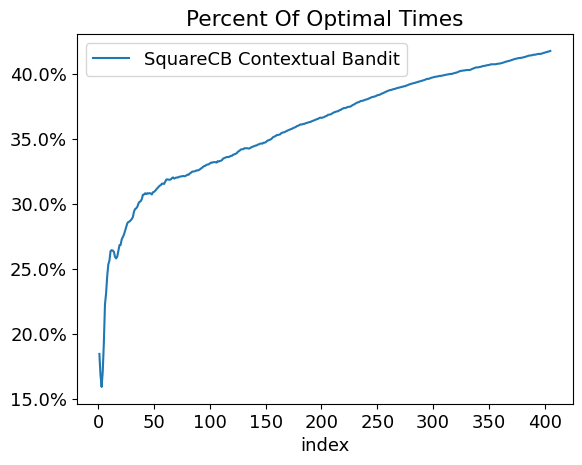

In [293]:
import matplotlib.ticker as mtick

x = df[df.learner_id.isin([14])].groupby(['learner_id','index'])['tpr'].mean().reset_index().pivot(columns='learner_id',index='index',values='tpr')

x.columns = ["SquareCB Contextual Bandit"]
ax = x.plot(title='Percent Of Optimal Times')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))



<Axes: title={'center': 'False Positive Rate'}, xlabel='index'>

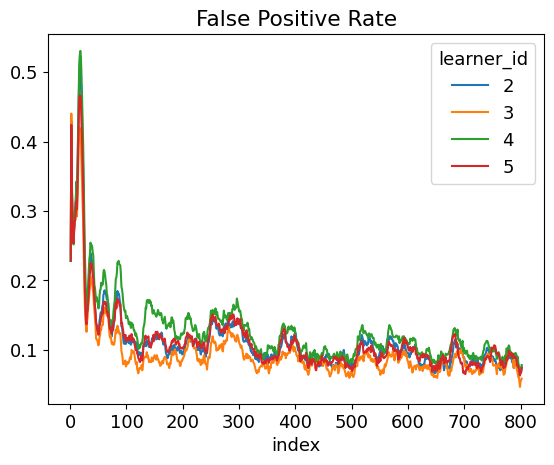

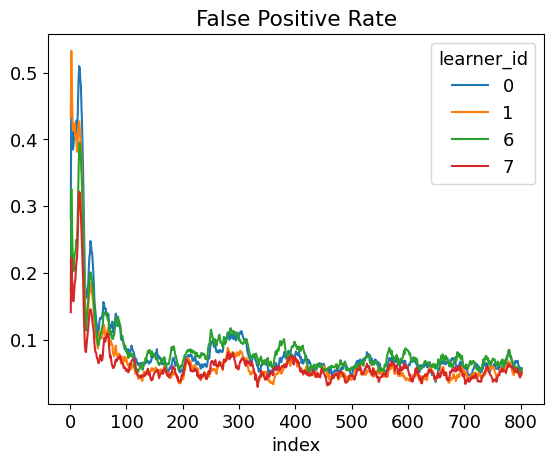

In [54]:
df = bdf.copy()
df = df[df.tl == 0]
df[['fp','fn']] = df[['fn','fp']] # due to a bug in code, we need to swap these

#fix index
df['index'] = 1
df['index'] = df.groupby(['environment_id','learner_id'])[['index']].expanding().sum().reset_index().drop('level_2',axis=1)['index'].tolist()

#make all environments equal length
df = df.groupby(['environment_id','learner_id']).head(n=df.groupby(['environment_id','learner_id'])['index'].max().min())

#calculate fpr using a window size
df['fpr'] = df.groupby(['environment_id','learner_id']).rolling(window=10,min_periods=0)['fp'].mean().reset_index().drop('level_2',axis=1)['fp'].tolist()

topn = 4

#get top 10 learner ids
top10 = df[df['index'] == df['index'].max()].groupby(['learner_id'])['fpr'].mean().reset_index().sort_values('fpr',ascending=False)['learner_id'][:topn].tolist()
bot10 = df[df['index'] == df['index'].max()].groupby(['learner_id'])['fpr'].mean().reset_index().sort_values('fpr',ascending=True )['learner_id'][:topn].tolist()

df[df.learner_id.isin(top10)].groupby(['learner_id','index'])['fpr'].mean().reset_index().pivot(columns= 'learner_id',index='index',values='fpr').plot(title='False Positive Rate')
df[df.learner_id.isin(bot10)].groupby(['learner_id','index'])['fpr'].mean().reset_index().pivot(columns= 'learner_id',index='index',values='fpr').plot(title='False Positive Rate')

<Axes: title={'center': 'False Discovery Rate'}, xlabel='index'>

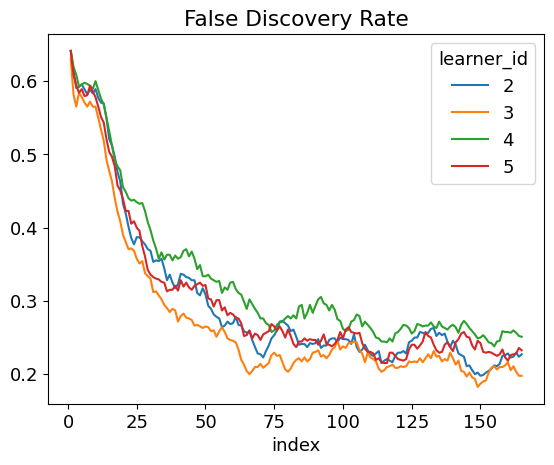

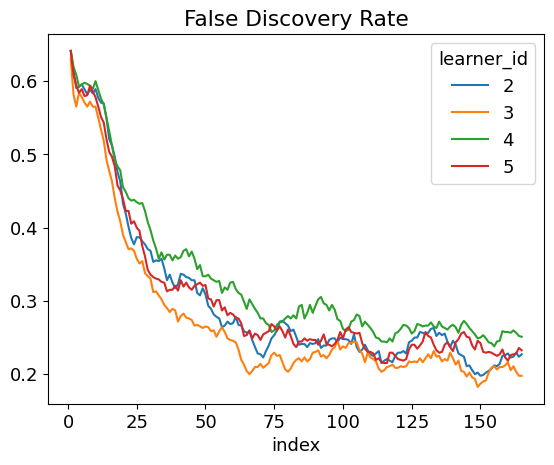

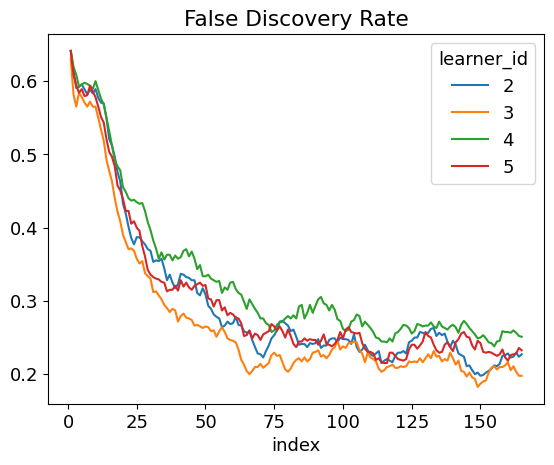

In [58]:
df = bdf.copy()
df = df[df.reward != 0]
df = df[df.learner_id.isin([2,3,4,5])]
df[['fp','fn']] = df[['fn','fp']] # due to a bug in code, we need to swap these

#fix index
df['index'] = 1
df['index'] = df.groupby(['environment_id','learner_id'])[['index']].expanding().sum().reset_index().drop('level_2',axis=1)['index'].tolist()

#make all environments equal length
df = df.groupby(['environment_id','learner_id']).head(n=df.groupby(['environment_id','learner_id'])['index'].max().min())

#calculate fdr using a window size
df['fdr'] = df.groupby(['environment_id','learner_id']).rolling(window=10,min_periods=0)['fp'].mean().reset_index().drop('level_2',axis=1)['fp'].tolist()

#topn = 4

#get top 10 learner ids
top10 = df[df['index'] == df['index'].max()].groupby(['learner_id'])['fdr'].mean().reset_index().sort_values('fdr',ascending=False)['learner_id'][:topn].tolist()
bot10 = df[df['index'] == df['index'].max()].groupby(['learner_id'])['fdr'].mean().reset_index().sort_values('fdr',ascending=True )['learner_id'][:topn].tolist()

df[df.learner_id.isin(top10)].groupby(['learner_id','index'])['fdr'].mean().reset_index().pivot(columns= 'learner_id',index='index',values='fdr').plot(title='False Discovery Rate')
df[df.learner_id.isin(bot10)].groupby(['learner_id','index'])['fdr'].mean().reset_index().pivot(columns= 'learner_id',index='index',values='fdr').plot(title='False Discovery Rate')

df[df.learner_id.isin(top10+bot10)].groupby(['learner_id','index'])['fdr'].mean().reset_index().pivot(columns= 'learner_id',index='index',values='fdr').plot(title='False Discovery Rate')

In [262]:
df

environment_id  learner_id  evaluator_id  index  fn  fp  r1  reward  \
12367                 0           9             0    1.0   0   0   1       1   
12368                 0           9             0    2.0   0   0   1       1   
12370                 0           9             0    3.0   0   1  -1      -1   
12371                 0           9             0    4.0   0   1  -1      -1   
12375                 0           9             0    5.0   0   0   1       1   
...                 ...         ...           ...    ...  ..  ..  ..     ...   
2453521              91          12             0  195.0   0   0   1       1   
2453522              91          12             0  196.0   0   0   1       1   
2453524              91          12             0  197.0   0   0   1       1   
2453534              91          12             0  198.0   0   0   1       1   
2453535              91          12             0  199.0   0   0   1       1   

         tl  tn  tp  tp+tn       fdr  
12367     1   0   1      1  0.000000  
12368     1   0   1      1  0.000000  
12370     0   0   0      0  0.333333  
12371     0   0   0      0  0.500000  
12375     1   0   1      1  0.400000  
...      ..  ..  ..    ...       ...  
2453521   1   0   1      1  0.400000  
2453522   1   0   1      1  0.300000  
2453524   1   0   1      1  0.300000  
2453534   1   0   1      1  0.300000  
2453535   1   0   1      1  0.200000  

[54924 rows x 13 columns]

environment_id  learner_id  evaluator_id  index  fn  fp  r1  reward  \
0                     0           0             0      1   1   0  -1      -1   
1                     0           0             0      2   0   1   1       0   
2                     0           0             0      3   0   1   1       0   
3                     0           0             0      4   1   0  -1      -1   
4                     0           0             0      5   0   0  -1       0   
...                 ...         ...           ...    ...  ..  ..  ..     ...   
6226067              91          37             0   1657   0   0  -1       0   
6226068              91          37             0   1658   0   0  -1       0   
6226069              91          37             0   1659   0   1   1       0   
6226070              91          37             0   1660   0   0  -1       0   
6226071              91          37             0   1661   0   1   1       0   

         tl  tn  tp  tp+tn  
0         0   0   0      0  
1         1   0   0      0  
2         1   0   0      0  
3         0   0   0      0  
4         0   1   0      1  
...      ..  ..  ..    ...  
6226067   0   1   0      1  
6226068   0   1   0      1  
6226069   1   0   0      0  
6226070   0   1   0      1  
6226071   1   0   0      0  

[6226072 rows x 12 columns]

In [237]:
df = bdf[bdf.reward != 0].copy()
df[['fp','fn']] = df[['fn','fp']] # due to a bug in code, we need to swap these
df = df[df.learner_id.isin(tprtop10[:4])]

#fix index
df['index'] = 1
df['index'] = df.groupby(['environment_id','learner_id'])[['index']].expanding().sum().reset_index().drop('level_2',axis=1)['index'].tolist()

In [238]:
df.groupby(['environment_id','learner_id'])['index'].max().sort_values()[:40]

environment_id  learner_id
89              34              5.0
                28              5.0
                32              6.0
80              34              6.0
1               34              7.0
77              34              8.0
3               28              8.0
6               32              8.0
3               24             10.0
6               24             11.0
61              28             12.0
14              32             12.0
30              24             12.0
1               32             14.0
3               32             16.0
29              24             17.0
36              24             17.0
                32             22.0
42              24             22.0
30              28             23.0
76              28             23.0
                24             28.0
30              32             32.0
58              32             38.0
50              24             41.0
58              28             50.0
12              28             62.0
 

In [223]:
#df = out.interactions.to_pandas()
#df[['fp','fn']] = df[['fn','fp']] # due to a bug in code, we need to swap these
tp = (df[(df.learner_id == 36) & (df.environment_id == 50)].reward == 1).sum()
p  = (df[(df.learner_id == 36) & (df.environment_id == 50)].tl == 1).sum()

In [5]:
df1 = out.interactions.to_pandas()
df1 = df1[df1.reward != 0]

df2 = out.where(reward={'!=':0}).interactions.to_pandas()

In [11]:
df1.reset_index(drop=True)

environment_id  learner_id  evaluator_id  index  fn  fp  r1  reward  \
0                    0           0             0      2   0   0   1       1   
1                    0           0             0      5   1   0  -1      -1   
2                    0           0             0      6   1   0  -1      -1   
3                    0           0             0      7   1   0  -1      -1   
4                    0           0             0      9   0   0   1       1   
...                ...         ...           ...    ...  ..  ..  ..     ...   
672571              91          14             0   1654   1   0  -1      -1   
672572              91          14             0   1655   0   0   1       1   
672573              91          14             0   1656   0   0   1       1   
672574              91          14             0   1659   0   0   1       1   
672575              91          14             0   1661   0   0   1       1   

        tl  tn  tp  tp+tn  
0        1   0   1      1  
1        0   0   0      0  
2        0   0   0      0  
3        0   0   0      0  
4        1   0   1      1  
...     ..  ..  ..    ...  
672571   0   0   0      0  
672572   1   0   1      1  
672573   1   0   1      1  
672574   1   0   1      1  
672575   1   0   1      1  

[672576 rows x 12 columns]

In [ ]:
import torch
import coba as cb

def all_pids():
    import pandas as pd
    return set(pd.read_csv(f'data/sims_main1.csv')['participant_id'])

class SimsEnvironment:

    def __init__(self, feats, lbl, pid, pscaler=None, gscaler=None, S=True, T=False, C=False, winstp=None):
        self._pid  = pid
        self._fts  = feats
        self._lbl  = lbl
        self._pscl = pscaler
        self._gscl = gscaler
        self._fts2 = (S,T,C)
        self._winstp = winstp

        hdrs = ['feats','lbl','pid','pscale','gscale','S','T','C','winstp']
        vals = [feats,lbl,str(pid),str(pscaler),str(gscaler),str(S),str(T),str(C),winstp]

        self._params  = dict(zip(hdrs,vals))

        if pscaler  is None: self._params.pop('pscale')
        if gscaler  is None: self._params.pop('gscale')

    @property
    def params(self):
        return self._params

    def read(self):
        import pandas as pd

        (S,T,C) = self._fts2
        df = pd.read_csv(f'data/sims_main1.csv')[['participant_id','experience_id','phase_id']].drop_duplicates()

        if S: df = pd.merge(df, self._sensor_df ())
        if T: df = pd.merge(df, self._trait_df  ())
        if C: df = pd.merge(df, self._context_df())

        if self._gscl:
            is_feat = df.columns[3:]
            df[is_feat] = df[is_feat].astype(float)
            df[is_feat] = self._gscl.fit_transform(df[is_feat].to_numpy().astype(float))

        ssl = S

        if     ssl: X = df.groupby(['participant_id','phase_id','experience_id']).head(n=-1).reset_index(drop=True)
        if     ssl: Y = df.groupby(['participant_id','phase_id','experience_id']).tail(n=-1).reset_index(drop=True)
        if not ssl: X = df
        if not ssl: Y = df[['participant_id','phase_id','experience_id']]

        L = self._label_df()

        #we merge with Y/X to handle when L isn't there for every X/Y
        Y = pd.merge(Y,L)
        X = pd.merge(X,L).iloc[:,:-1]

        G = X.loc[:,'participant_id']
        X = X.iloc[:,3:].to_numpy().astype(float).tolist()
        Y = Y.iloc[:,3:].to_numpy().astype(float).tolist()

        for x,y,g in zip(X,Y,G):
            yield {'context':x, 'rewards':[0, 1 if y[-1]==1 else -1], 'actions':[(1,0),(0,1)], 'pid': g}

    def _sensor_df(self):
        import pandas as pd

        if self._fts == 'main1' : df = pd.read_csv(f'data/sims_main1.csv')
        if self._fts == 'main2' : df = pd.read_csv(f'data/sims_main2.csv')
        if self._fts == 'series': df = pd.read_csv(f'data/sims_series.csv')

        if self._pscl:
            is_feat = df.columns[3:]
            df[is_feat] = df[is_feat].astype(float)
            for pid in set(df.participant_id):
                is_pid = df.participant_id==pid
                df.loc[is_pid,is_feat] = self._pscl.fit_transform(df.loc[is_pid,is_feat])

        if self._winstp:
            win,stp = self._winstp
            feats,labels  = [],[]
            for i,g in df.groupby(['experience_id','participant_id','phase_id']):
                n_wins = (g.shape[0]-win)//stp
                array  = g.iloc[:,3:].to_numpy()
                for j in range(n_wins):
                    feats.append(array[j*stp:j*stp+win,:].flatten())
                    labels.append(i)
            df1 = pd.DataFrame(labels,columns=['experience_id','participant_id','phase_id'])
            df2 = pd.DataFrame(feats)
            df = pd.concat([df1,df2],axis=1)

        return df

    def _trait_df(self):
        import pandas as pd
        old_names = ['PID','SIAS_sum','BFNE_sum','DERS_SF_mean_all','dass_dep_sum']
        new_names = ['participant_number','SIAS','BFNE','DERS','DASS']
        trt = pd.read_csv('data/trait_data.csv').rename(columns=dict(zip(old_names,new_names)))
        prt = pd.read_csv('data/participants.csv')
        prt.participant_number = prt.participant_number.str[1:].astype(int)
        return pd.merge(trt,prt)[['participant_id','SIAS','BFNE','DERS','DASS']]

    def _context_df(self):
        import pandas as pd
        df = pd.read_csv('data/context.csv')
        df['phase' ] = df.phase_id
        df['phase1'] = (df.phase_id == 1).astype(int)
        df['phase2'] = (df.phase_id == 2).astype(int)
        df['phase3'] = (df.phase_id == 3).astype(int)
        return df

    def _label_df(self):
        import pandas as pd

        if self._lbl == 'is_pre':
            df = pd.read_csv('data/sims_labels.csv')
            df['label'] = ((df['experience_id'] != 1) & (df['phase_id'] == 1)).astype(int)
            return df[['participant_id','experience_id','phase_id','label']]

        if self._lbl == 'is_pp':
            df = pd.read_csv('data/sims_labels.csv')
            df['label'] = ((df['experience_id'] != 1) & (df['phase_id'].isin([1,3]))).astype(int)
            return df[['participant_id','experience_id','phase_id','label']]

        if self._lbl == 'sub_anx':
            rpt = pd.read_csv('data/self_reports.csv')
            prt = pd.read_csv('data/participants.csv')

            rpt = rpt[rpt.phase      != 'baseline'   ]
            rpt = rpt[rpt.experience != 'alone_video']        
            rpt['participant_number'] = rpt['PID']

            prt.participant_number = prt.participant_number.str[1:].astype(int)
            prt = prt[['participant_id','participant_number']]
    
            cols = ['experience_id','experience']
            data = [[1,'alone_video'],[2,'dyad_evaluative'],[3,'group_evaluative'],[4,'dyad_non_evaluative'],[5,'group_non_evaluative']]
            exp  = pd.DataFrame(data=data,columns=cols)
    
            cols = ['phase_id','phase']
            data = [[1,'anticipatory anxiety'],[2,'experience'],[3,'post-event']]
            phs  = pd.DataFrame(data=data,columns=cols)
    
            L = rpt[['participant_number','experience','phase','calm_anx']]
            L = pd.merge(pd.merge(pd.merge(L,exp),phs),prt)
            L = L[['participant_id','experience_id','phase_id','calm_anx']]
    
            L['calm_anx'] = L['calm_anx'].astype(float)
            L['calm_anx'] = (L['calm_anx'] > 3).astype(float)
    
            return L
    
    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps([self._fts,self._lbl,self._pid,self._pscl,self._gscl,*self._fts2,self._winstp])

    def __setstate__(self,state):
        import cloudpickle
        self.__init__(*cloudpickle.loads(state))

class Feedforward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def __init__(self, specs):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                int -- a LinearLayer with output width equal to int
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        def make_layer(curr_dim,spec):
            if isinstance(spec,float):
                return torch.nn.Dropout(spec), curr_dim
            if curr_dim is None and isinstance(spec,int):
                return None, spec
            if isinstance(spec,int):
                return torch.nn.Linear(curr_dim,spec),spec
            if spec == 'r':
                return torch.nn.ReLU(),curr_dim
            if spec == 'l':
                return torch.nn.LayerNorm(curr_dim),curr_dim
            if spec == 's':
                return torch.nn.Sigmoid(),curr_dim
            if isinstance(spec,list):
                return Feedforward.SkipModule(Feedforward([curr_dim] + spec)), curr_dim

        layers,width = [],None
        for spec in specs:
            layer,width = make_layer(width,spec)
            if layer: layers.append(layer)

        super().__init__(*layers)

class FeedforwardCB(torch.nn.Module):

    def __init__(self, specs, aembed):
        super().__init__()
        self.aembed = torch.nn.Embedding(*aembed) if aembed else lambda x:x
        self.layers = Feedforward(specs)

    def forward(self,contexts,actions):
        return self.layers(torch.cat([contexts,self.aembed(actions)],dim=1))

class FeedForwardSquareCb:

    def __init__(self, specs, adim=None, gamma='lambda t: 1000', tz=1):
        self.loss       = torch.nn.MSELoss()
        self.fhat       = None
        self.opt        = None
        self.sched      = None
        self._adim      = adim
        self._specs     = specs
        self._params    = {'layers': specs, 'gamma':gamma, 'adim':adim, 'tz':tz}
        self._gamma     = eval(gamma)
        self._rng       = cb.CobaRandom(1)
        self._t         = tz

    @property
    def params(self):
        return self._params

    def define(self,context,actions):
        import parameterfree
        torch.manual_seed(1)
        torch.set_num_threads(1)

        cdim   = len(context)
        adim   = self._adim or len(actions[0])
        xdim   = adim+cdim
        aembed = (len(actions),adim) if self._adim else None

        islist = lambda s: isinstance(s,list)
        isneg1 = lambda s: s == -1

        def prep(specs):
            return [ xdim if isneg1(s) else prep(s) if islist(s) else s for s in specs ]

        self.fhat  = FeedforwardCB(prep(self._specs), aembed)
        self.opt   = parameterfree.COCOB(self.fhat.parameters())

    def predict(self, context, actions):
        if not self.opt: self.define(context,actions)

        with torch.no_grad():
            mu = len(actions)
            dt = torch.float32

            X    = torch.tensor(context,dtype=dt).repeat(len(actions),1)
            A    = torch.tensor(actions,dtype=dt) if not self._adim else torch.arange(len(actions))
            yhat = self.fhat.eval()(X,A)

            rvals       = torch.reshape(yhat, (1,-1))
            rmaxs,ridxs = rvals.max(axis=1,keepdim=True)
            rgaps       = rmaxs-rvals

            probs = 1/(mu+self._gamma(self._t)*rgaps)
            probs[range(1),ridxs.squeeze()] += 1-probs.sum(axis=1)

        return self._rng.choicew(actions,probs[0].tolist())

    def learn(self, context, action, reward, score):
        self._t += 1
        dt = torch.float32

        X    = torch.tensor([context],dtype=dt)
        A    = torch.tensor([action],dtype=dt) if not self._adim else torch.tensor([action.index(1)])
        y    = torch.tensor([reward],dtype=dt)
        yhat = self.fhat.eval()(X,A)[0]
        loss = self.loss(yhat, y).mean()

        self.opt.zero_grad()
        loss.backward()

        self.opt.step()
        if self.sched: self.sched.step()

class FeedForwardSimsCb:

    def __init__(self, specs, gamma='lambda t: 1000', tz=1, trn_pct=.9, reset_out=False, prtr_scl=1):
        self.loss       = torch.nn.MSELoss()
        self.fhat       = None
        self.opt        = None
        self.sched      = None
        self._specs     = specs
        self._gamma     = eval(gamma)
        self._rng       = cb.CobaRandom(1)
        self._t         = tz
        self._trn_pct   = trn_pct
        self._reset_out = reset_out
        self._prtr_scl  = prtr_scl
        self._params    = {'layers': specs, 'gamma':gamma, 'tz':tz, 'trn_pct': trn_pct, 'reset_out': reset_out, 'prtr_scl':prtr_scl}

    @property
    def params(self):
        return self._params

    def warmstart(self,warmstart):
        from parameterfree import COCOB

        if not warmstart or self._trn_pct == 0: return

        def extract(rows,dt=torch.float32):
            X,A,y = zip(*((r['context'],r['action'],r['reward']) for r in rows ))
            return torch.tensor(X,dtype=dt), torch.tensor(A,dtype=dt), torch.tensor(y,dtype=dt).unsqueeze(dim=1)

        self.define(warmstart[0]['context'],warmstart[0]['actions'])        

        trn_size     = int(len(warmstart)*self._trn_pct)
        trn_X, trn_y = extract(warmstart[:trn_size])
        val_X, val_y = extract(warmstart[trn_size:])

        trn_y = torch.tensor(self._prtr_scl,dtype=torch.float32)*trn_y
        val_y = torch.tensor(self._prtr_scl,dtype=torch.float32)*val_y
        
        fhat = self.fhat
        loss = self.loss
        opt  = COCOB(fhat.parameters())

        torch.manual_seed(1)
        torch_dataset = torch.utils.data.TensorDataset(trn_X,trn_y)
        torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

        with torch.no_grad():
            stp_criteria = 0
            new_trn_loss = loss(fhat(trn_X),trn_y)
            new_val_loss = loss(fhat(val_X),val_y)

        for _ in range(50):
            for X,y in torch_loader:
                opt.zero_grad()
                loss(fhat(X),y).backward()
                opt.step()
            with torch.no_grad():
                old_trn_loss, new_trn_loss = new_trn_loss, loss(fhat(trn_X),trn_y)
                old_val_loss, new_val_loss = new_val_loss, loss(fhat(val_X),val_y)
                stp_criteria = (stp_criteria +1)*(new_val_loss > old_val_loss).item()
                if stp_criteria == 2: break
        
        if self._reset_out:
            torch.nn.init.xavier_uniform_(fhat[-1].weight.data)
    
    def define(self, context, actions):
        import parameterfree
        torch.manual_seed(1)
        torch.set_num_threads(1)

        xdim   = len(context)
        islist = lambda s: isinstance(s,list)
        isneg1 = lambda s: s == -1

        def prep(specs):
            return [ xdim if isneg1(s) else prep(s) if islist(s) else s for s in specs ]

        self.fhat  = Feedforward(prep(self._specs))
        self.opt   = parameterfree.COCOB(self.fhat.parameters())

    def predict(self, context, actions):
        if not self.opt: self.define(context,actions)

        with torch.no_grad():
            mu = len(actions)
            dt = torch.float32

            X    = torch.tensor(context,dtype=dt)
            yhat = torch.tensor([0,self.fhat.eval()(X)],dtype=dt)

            rvals       = torch.reshape(yhat, (1,-1))
            rmaxs,ridxs = rvals.max(axis=1,keepdim=True)
            rgaps       = rmaxs-rvals

            probs = 1/(mu+self._gamma(self._t)*rgaps)
            probs[range(1),ridxs.squeeze()] += 1-probs.sum(axis=1)

        return self._rng.choicew(actions,probs[0].tolist())

    def learn(self, context, action, reward, score):
        self._t += 1
        dt = torch.float32

        if action[1] == 1:
            X    = torch.tensor([context],dtype=dt)
            y    = torch.tensor([reward],dtype=dt)
            yhat = self.fhat.eval()(X)[0]

            self.opt.zero_grad()
            self.loss(yhat, y).backward()    
            self.opt.step()

            if self.sched: self.sched.step()

from copy import deepcopy
from typing import Tuple,Sequence, Mapping, Any, Hashable
from coba import Learner, SafeLearner, VowpalMediator, VowpalLearner, Namespaces, Context, Actions, Action

class EMT:

    def __init__(self, split:int = 100, scorer:str="self_consistent_rank", bound:int=0, features: Sequence[str]=[1,'a','xa']) -> None:

        self._params = {'split':split, 'scorer':scorer, 'bound':bound, 'features':features}

        feat_args = []
        if 1   not in features: feat_args.append('--noconstant')
        if 'a' not in features: feat_args.append('--ignore_linear a')
        if 'x' not in features: feat_args.append('--ignore_linear x')
        feat_args += [ f'--interactions {f}' for f in features if f not in {1, 'a', 'x'} ]

        vw_args = [
            "--emt",
            f"--emt_tree {bound}",
            f"--emt_leaf {split}",
            f"--emt_scorer {scorer}",
            f"--emt_router {'eigen'}",
            f"-b {21}",
            f"--min_prediction 0",
            f"--max_prediction 3",
            f"--coin",
            f"--initial_weight 0",
            *feat_args,
            f'--quiet',
            f'--random_seed 1337'
        ]

        self._vw = VowpalMediator()
        self._vw_args = ' '.join(vw_args)

    @property
    def params(self) -> Mapping[str,Any]:
        return self._params
    
    def predict(self, X: Mapping) -> int:
        if not self._vw.is_initialized: self._vw.init_learner(self._vw_args, label_type=2)
        return int(self._vw.predict(self._vw.make_example(X, None)))

    def learn(self, X: Mapping, y: int, weight: float):
        if not self._vw.is_initialized: self._vw.init_learner(self._vw_args, label_type=2)
        self._vw.learn(self._vw.make_example(X, f"{int(y)} {weight}"))

class EmtStackedLearner:

    def __init__(self, emt: EMT, learner: Learner) -> None:
        self._emt  = deepcopy(emt)
        self._lrn  = SafeLearner(deepcopy(learner))
        self._isvw = isinstance(learner,VowpalLearner)

    @property
    def params(self) -> Mapping[str,Any]:
        params = {**self._emt.params, **self._lrn.params, 'family': 'EigenStacked'}
        params.pop('args',None)
        return params

    def _inner_actions(self, context) -> float:
        return 

    def warmstart(self,warmstart):

        if not warmstart or self._lrn.learner._trn_pct == 0: return

        warmstart = list(warmstart)
        for row in warmstart:
            context = row['context']
            reward = row['rewards'](row['actions'][1])
            pred_rwd = float(self._emt.predict({'x':context}))
            self._emt.learn({'x':context}, reward, 1)
            row['context'] = [*context,pred_rwd]

        self._lrn.learner.warmstart(warmstart)

    def score(self, context: Context, actions: Actions, action: Action) -> float:
        inner_actions = self._inner_actions(context,actions)
        inner_action  = inner_actions[actions.index(action)]
        return self._lrn.score(context,inner_actions,inner_action)

    def predict(self, context: Context, actions: Actions) -> Tuple[Action,float]:
        """Choose which action index to take."""

        pred_rwd = float(self._emt.predict({'x':context}))
        return self._lrn.predict([*context,pred_rwd],actions)

    def learn(self, context: Hashable, action: Hashable, reward: float, score: float) -> None:
        """Learn about the result of an action that was taken in a context."""
        if action[1] == 1:
            pred_rwd = float(self._emt.predict({'x':context}))
            self._emt.learn({'x':context}, reward, 1)
            self._lrn.learn([*context,pred_rwd], action, reward, score)

class RepeatEval:
    def __init__(self, trn_size, val_size):
        assert trn_size == 0 or val_size > 0
        assert trn_size >= 0 and val_size >=0

        self._trn_size = trn_size
        self._val_size = val_size

    @property
    def params(self):
        return {'trn_size': self._trn_size, 'val_size': self._val_size}

    def evaluate(self, env, lrn):
        from parameterfree import COCOB
        from coba.pipes import IterableSource

        def extract(rows,dt=torch.float32):
            X,A,y = zip(*((r['context'],r['action'],r['reward']) for r in rows ))
            return torch.tensor(X,dtype=dt), torch.tensor(A,dtype=dt), torch.tensor(y,dtype=dt).unsqueeze(dim=1)

        trn = list(islice(rows,self._trn_size))
        val = list(islice(rows,self._val_size))
        tst = list(rows)

        trn_X, trn_A, trn_y = extract(trn)
        val_X, val_A, val_y = extract(val)

        fhat = self.fhat
        loss = self.loss
        opt  = COCOB(fhat.parameters())

        self.define(tst[0]['context'],tst[0]['actions'])
        
        torch.manual_seed(1)
        torch_dataset = torch.utils.data.TensorDataset(trn_X,trn_A,trn_y)
        torch_loader  = torch.utils.data.DataLoader(torch_dataset,batch_size=64,drop_last=True,shuffle=True)

        with torch.no_grad():
            stp_criteria = 0
            new_trn_loss = loss(fhat(trn_X,trn_A),trn_y)
            new_val_loss = loss(fhat(val_X,val_A),val_y)

        for _ in range(50):
            for X,A,y in torch_loader:
                opt.zero_grad()
                loss(fhat(X,A),y).backward()
                opt.step()
            with torch.no_grad():
                old_trn_loss, new_trn_loss = new_trn_loss, loss(fhat(trn_X,trn_A),trn_y)
                old_val_loss, new_val_loss = new_val_loss, loss(fhat(val_X,val_A),val_y)
                stp_criteria = (stp_criteria +1)*(new_val_loss > old_val_loss).item()
                if stp_criteria == 2: break

        yield from cb.SequentialCB().evaluate(IterableSource(tst),lrn)


In [1]:
import torch
import coba as cb

class Feedforward(torch.nn.Sequential):
    """A Generic implementation of Feedforward Neural Network"""

    class SkipModule(torch.nn.Module):
        def __init__(self, layers):
            super().__init__()
            self.layers = layers
        def forward(self,X):
            return X + self.layers(X)

    def __init__(self, specs):
        """Instantiate a Feedfoward network according to specifications.

        Args:
            specs: A sequence of layer specifications as follows:
                -1 -- replaced with the input feature width
                int -- a LinearLayer with output width equal to int
                [0,1] -- a Dropout layer with the given probability
                'l' -- a LayerNorm
                'r' -- a ReLU layer
                's' -- a Sigmoid layer
                [] -- a skip layer with the given specifications
        """

        def make_layer(curr_dim,spec):
            if isinstance(spec,float):
                return torch.nn.Dropout(spec), curr_dim
            if curr_dim is None and isinstance(spec,int):
                return None, spec
            if isinstance(spec,int):
                return torch.nn.Linear(curr_dim,spec),spec
            if spec == 'r':
                return torch.nn.ReLU(),curr_dim
            if spec == 'l':
                return torch.nn.LayerNorm(curr_dim),curr_dim
            if spec == 's':
                return torch.nn.Sigmoid(),curr_dim
            if isinstance(spec,list):                
                return Feedforward.SkipModule(Feedforward([curr_dim] + spec)), curr_dim

        layers,width = [],None
        for spec in specs:
            layer,width = make_layer(width,spec)
            if layer: layers.append(layer)

        super().__init__(*layers)

class FeedforwardCB(torch.nn.Module):

    def __init__(self, specs, aembed):

        super().__init__()

        self.aembed = torch.nn.Embedding(*aembed) if aembed else lambda x:x
        self.layers = Feedforward(specs)

    def forward(self,context,actions):
        actions = self.aembed(actions)
        context = context.repeat(len(actions),1)
        return self.layers(torch.cat([context,actions],dim=1))

class FeedForwardSquareCb:

    def __init__(self, specs, adim=None, gamma='lambda t: 1000'):
        self.loss   = torch.nn.MSELoss(reduction='none')
        self.fhat    = None
        self.opt     = None
        self.sched   = None
        self._adim   = adim
        self._specs  = specs
        self._params = {'layers': specs, 'gamma':gamma, 'adim':adim}
        self._gamma  = eval(gamma)
        self._rng    = cb.CobaRandom(1)
        self._t      = 1

    @property
    def params(self):
        return self._params

    def define(self,context, actions):
        import parameterfree
        torch.manual_seed(1)
        torch.set_num_threads(1)

        cdim   = len(context)
        adim   = self._adim or len(actions[0])
        xdim   = adim+cdim
        aembed = (len(actions),adim) if self._adim else None

        islist = lambda s: isinstance(s,list)
        isneg1 = lambda s: s == -1

        def prep(specs):
            return [ xdim if isneg1(s) else prep(s) if islist(s) else s for s in specs ]

        self.fhat  = FeedforwardCB(prep(self._specs), aembed)
        self.opt   = parameterfree.COCOB(self.fhat.parameters())

    def predict(self, context, actions):
        if not self.opt: self.define(context,actions)
        
        with torch.no_grad():
            mu = len(actions)
            dt = torch.float32

            x    = torch.tensor(context,dtype=dt)
            A    = torch.tensor(actions,dtype=dt) if not self._adim else torch.arange(len(actions))
            yhat = self.fhat.eval()(x,A)

            rvals       = torch.reshape(yhat, (1,-1))
            rmaxs,ridxs = rvals.max(axis=1,keepdim=True)
            rgaps       = rmaxs-rvals

            probs = 1/(mu+self._gamma(self._t)*rgaps)
            probs[range(1),ridxs.squeeze()] += 1-probs.sum(axis=1)

        return self._rng.choicew(actions,probs[0].tolist())

    def learn(self, context, action, reward, score):
        if not self.opt: self.define(context,actions)

        self._t += 1
        dt = torch.float32

        x    = torch.tensor(context ,dtype=dt)
        A    = torch.tensor([action],dtype=dt) if not self._adim else torch.tensor([action.index(1)])
        y    = torch.tensor([reward],dtype=dt)
        yhat = self.fhat.eval()(x,A)[0]
        loss = self.loss(yhat, y).mean()

        self.opt.zero_grad()
        loss.backward()

        self.opt.step()
        if self.sched: self.sched.step()

class RepeatEval:
    def __init__(self, trn_size, val_size):
        assert trn_size == 0 or val_size > 0
        assert trn_size >= 0 and val_size >=0

        self._trn_size = trn_size
        self._val_size = val_size

    @property
    def params(self):
        return {'trn_size': self._trn_size, 'val_size': self._val_size }

    def evaluate(self, env, lrn):
        from coba.pipes import Pipes, IterableSource, Shuffle
        from operator import itemgetter
        from itertools import islice

        first,rows = cb.peek_first(env.read())

        if first is None: return

        trn = IterableSource(list(islice(rows,self._trn_size)))
        val = IterableSource(list(islice(rows,self._val_size)))
        tst = IterableSource(rows)

        trainer   = cb.SequentialCB(eval=None)
        validator = cb.SequentialCB(record='reward',learn=None)
        tester    = cb.SequentialCB()

        if self._trn_size > 0:
            new_val_score = 0
            for i in range(20): #20 to make sure we don't loop forever (though we shouldn't ever hit 20)
                old_val_score = new_val_score
                if isinstance(lrn, FeedForwardSquareCb): lrn._t = 1 #reset exploration to make sure we fairly compare
                list(trainer.evaluate(Pipes.join(trn,Shuffle(i)),lrn))
                new_val_score = sum(map(itemgetter('reward'),validator.evaluate(val,lrn)))
                if new_val_score < old_val_score: break # our latest iteration on train appears to have overfit, stop training

        yield from tester.evaluate(tst,lrn)

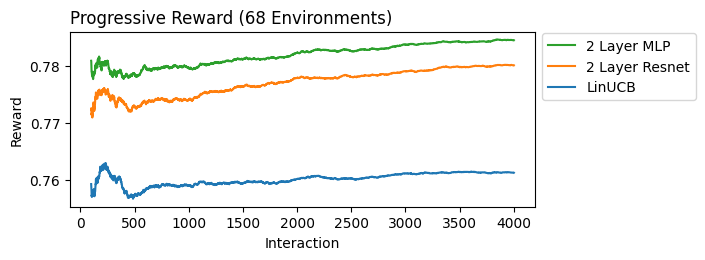

In [30]:
import coba as cb

reslayer = lambda w: ['l', 'r', w, 'l', 'r', w]
mlp_spec = lambda width: [-1, width, 'l', 'r', width, 'l', 'r', 1]
res_spec = lambda width: [-1, width, reslayer(width), reslayer(width), 1]

env = cb.Environments.from_feurer().where(n_features=(None,1000)).reservoir(8000,strict=True).scale('mean','std')
lrn = [cb.LinUCBLearner(), FeedForwardSquareCb(mlp_spec(80), gamma=gamma), FeedForwardSquareCb(res_spec(80), gamma=gamma)]
evl = RepeatEval(3000,1000)

out = cb.Experiment(env,lrn,evl).run(processes=35,quiet=True)
out.plot_learners(xlim=(100,None),labels=['LinUCB','2 Layer Resnet', '2 Layer MLP'])

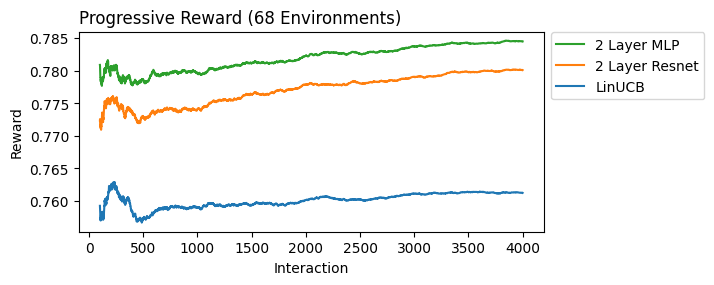

In [28]:
plt.figure(figsize=(6,3.5))
out.plot_learners(xlim=(100,None),labels=['LinUCB','2 Layer Resnet', '2 Layer MLP'],out=None)
plt.legend(loc='upper left',bbox_to_anchor=(1,1.03))
plt.show()

In [27]:
out = out.filter_fin(l='learner_id',p='environment_id')

We removed 12 environment_id because they did not exist for every learner_id.


In [2]:
import coba as cb
#cb.Result.from_file('networks2.log.gz').plot_learners()

We shortened 540 learner evaluations because they were longer than the shortest environment.


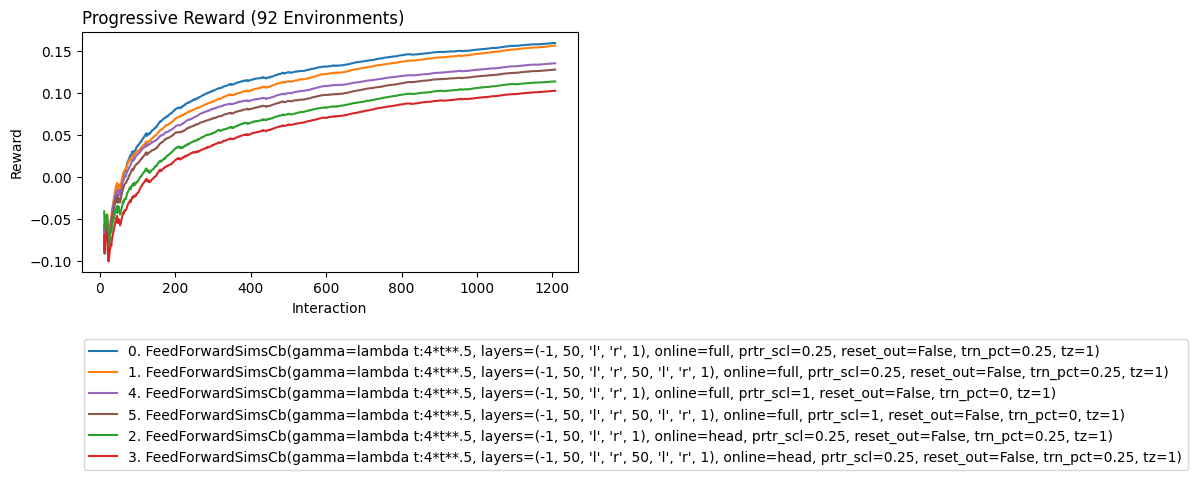

We shortened 540 learner evaluations because they were longer than the shortest environment.


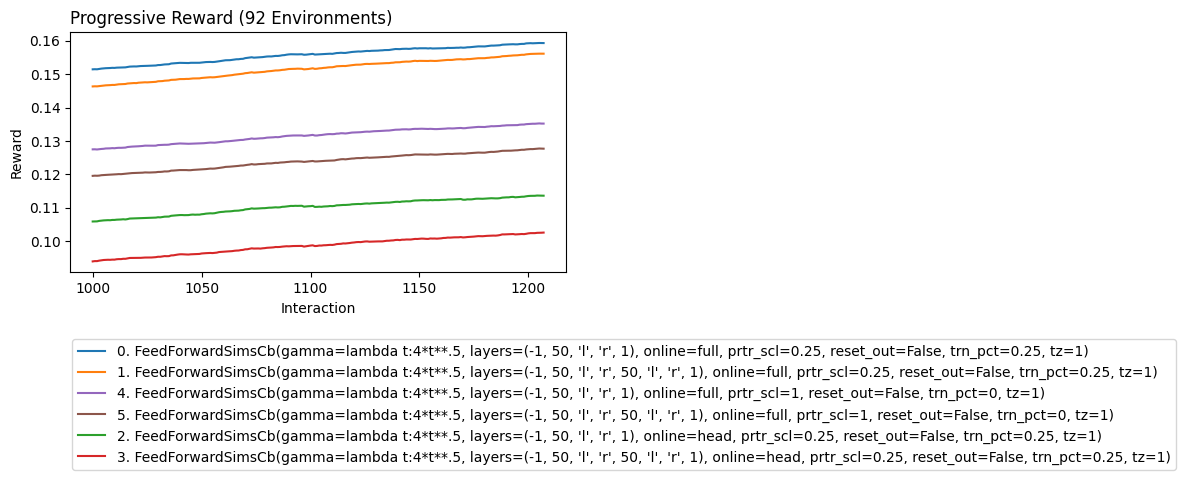

We shortened 552 learner evaluations because they were longer than the shortest environment.


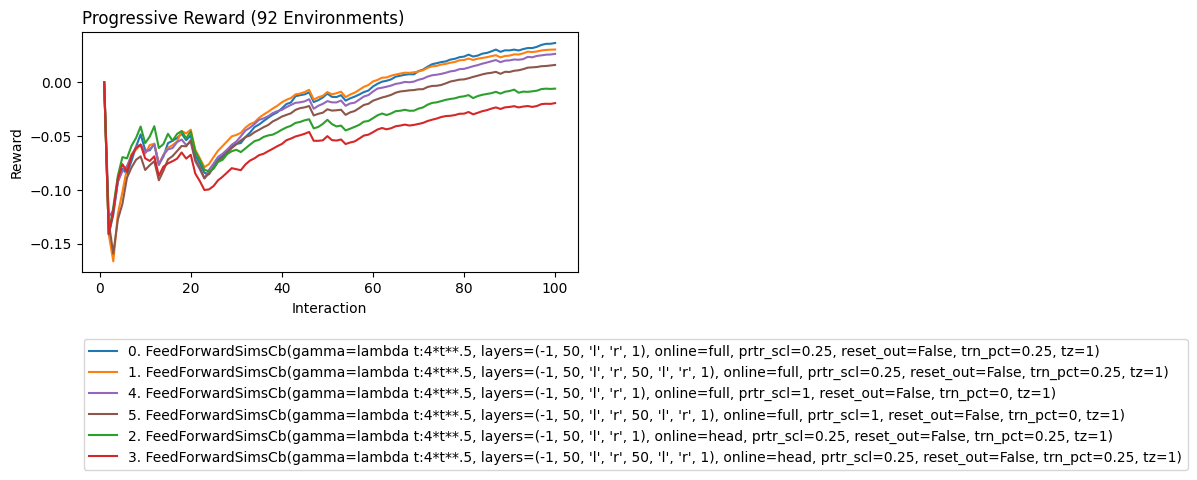

In [2]:
def local(log,cores):
    from itertools import product
    from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

    feats    = ['series']
    pids     = all_pids()
    pscalers = [RobustScaler()]
    gscalers = [None]

    envs = []
    for feat,pid,pscaler,gscaler in product(feats,pids,pscalers,gscalers):
        envs.append(SimsEnvironment(feat,'is_pp',pid,pscaler,gscaler,True,False,False,(6,5) if feat == 'series' else None))
    env = cb.Environments(*envs).shuffle(n=2)

    preres = lambda w: ['l', 'r', w, 'l', 'r', w]

    lrn = []
    for t,o,p,w,g in product([.25],['full','head'],[.25],[50],[4]):
        lrn.append(FeedForwardSimsCb([-1, w, 'l', 'r',              1], f'lambda t:{g}*t**.5', 1, t, False, p, o))
        lrn.append(FeedForwardSimsCb([-1, w, 'l', 'r', w, 'l', 'r', 1], f'lambda t:{g}*t**.5', 1, t, False, p, o))
    for w,g in product([50],[4]):
        lrn.append(FeedForwardSimsCb([-1, w, 'l', 'r',              1], f'lambda t:{g}*t**.5', 1, 0))
        lrn.append(FeedForwardSimsCb([-1, w, 'l', 'r', w, 'l', 'r', 1], f'lambda t:{g}*t**.5', 1, 0))

    return cb.Experiment(env,lrn,LooSimsEval()).run(log,processes=cores,quiet=True)

out = local('fullpp6.log.gz',38)
out = cb.Result.from_file('fullpp6.log.gz')
out.plot_learners(xlim=(12,None))
out.plot_learners(xlim=(1000,None))
out.filter_fin(100).plot_learners()